In [7]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [8]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [9]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [10]:
qfl_factors = globals()['qfl_{0}'.format('Momentum').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [11]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [12]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [13]:
qfl_df = df

In [14]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)"
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,-13.719374,123.978190,0.776841,79.959130,45.728226,77.684135,81.52811,83.626340,62.431100,46.331880,50.997080,57.121586,55.959446,9.548962,-9.242762,76.611664,182.391620,314.18430,0.303888,-10.394615,53.577350,95.770200,112.126396,-0.130529,-0.045580,-0.262566,-2.795292,-2.318713,-0.094575,0.002134,0.001860,0.251615,0.040650
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,-8.069223,61.537888,0.812737,50.701797,48.675243,81.273674,87.65116,89.833626,56.164803,42.350544,47.600063,55.936695,56.120780,6.005824,-7.347292,41.059780,161.102550,309.99084,-6.721079,-8.521212,22.464966,101.224045,164.919750,0.005108,-0.061650,-0.150090,-2.652300,-2.503783,-0.039345,-0.001657,-0.000232,0.062859,0.022840
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,-10.815960,94.832590,0.800537,52.299118,43.602207,80.053665,84.17267,87.518560,52.598618,47.236030,50.641930,53.840717,54.879868,4.343998,-10.290670,79.968540,169.219470,376.54030,-5.603766,-11.446655,62.181057,92.404090,154.642140,-0.019399,0.006574,-0.288269,-2.031178,-2.654821,0.014448,-0.002831,-0.001121,0.143003,-0.020558
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,-9.091806,102.019550,0.834695,49.025978,55.221110,83.469530,84.75089,87.134224,62.749317,51.269337,48.553980,50.068855,50.631550,5.267763,-8.439672,40.772556,56.321262,165.70416,-9.056783,-9.611583,23.270452,5.231512,39.348995,0.058973,-0.084950,-0.177061,-1.233387,-1.236259,-0.013041,0.005937,0.001693,0.181186,-0.002062
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,-3.152817,73.722480,0.928753,73.164770,86.070790,92.875280,93.24016,95.037224,59.314760,44.387608,45.781390,50.296570,48.040783,8.619928,1.878166,30.399109,72.383270,137.10477,-4.046965,0.616348,14.559817,23.846626,32.536460,-0.212334,-0.325848,-0.096825,-1.153151,-1.318660,-0.060791,0.018752,0.001740,0.098658,-0.003541


In [15]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)"
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,-25.854110,65.226340,0.530988,71.041670,76.794660,53.098824,46.053270,39.087547,70.444030,60.336680,51.629050,56.692220,58.185170,15.119516,16.528273,-15.997314,1.327825,2.729321,-4.062665,13.374400,-15.928674,-4.749912,-21.423077,-0.706679,-0.300669,0.153405,1.133499,0.622744,-0.189781,0.024009,0.004721,-0.212300,-0.044614
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,-36.538464,1.315784,0.022059,9.677419,7.142858,2.205882,1.562500,0.914634,41.823853,45.670338,53.253986,38.099728,41.090534,-4.545456,-11.753726,-31.444757,-28.908354,-48.727272,-10.446191,-16.267746,-32.790410,-31.757046,-54.859543,0.396366,0.234907,0.135430,1.057966,0.811768,-0.041330,-0.004822,0.000226,-0.017875,-0.010490
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,-29.515617,40.396750,0.407273,82.467540,83.089780,40.727270,38.290592,36.661210,68.188270,55.673450,47.213470,52.334812,51.370407,32.332207,17.535364,-20.933592,-13.735735,1.429307,1.902819,13.342810,-22.122175,-20.132530,-24.711334,-1.295614,-0.169618,0.191657,1.211271,0.492564,-0.230336,0.040483,0.003922,-0.204754,-0.061393
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,-60.721443,4.255319,0.025723,36.363636,10.126582,2.675585,1.072386,0.847458,52.434628,50.818264,51.520527,42.244870,50.578487,-2.970296,-23.437500,-58.562366,-70.388960,-76.422760,-13.599271,-34.226590,-60.454560,-73.810265,-83.129814,0.150811,0.546427,0.335890,4.405320,1.648773,-0.009096,0.010276,0.001121,-0.227648,-0.186098
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,-28.989113,9.759617,0.178855,8.493151,4.311543,17.885464,10.304568,10.304568,37.402992,42.067093,52.218315,52.992550,51.843468,-6.968218,-18.531597,-23.926289,-16.622948,-20.689148,-16.400068,-27.640450,-28.714973,-24.274563,-32.589172,0.471761,0.385889,0.058116,1.122816,0.523904,-0.082052,-0.000852,0.000715,-0.051922,-0.041300


In [16]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1598.000000,1598.000000,1598.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1552.000000,1517.000000,1598.000000,1596.000000,1592.000000,1552.000000,1517.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,-15.381298,81.754134,0.681103,70.516786,69.735171,68.122951,60.984402,61.595212,58.412282,52.327197,50.542756,51.235000,52.003483,14.438864,9.541012,10.658745,39.553629,97.821020,1.612766,3.371064,5.222949,21.916566,48.196959,-0.520718,-0.145056,-0.003956,0.045215,-0.459153,-0.077578,0.011715,0.002499,-0.002751,-0.040806
std,0.0,0.177252,7.256757,9.150908e+04,12.054825,76.940077,0.232672,24.020508,24.081925,23.213533,26.356512,27.182480,9.552641,5.123413,2.410028,6.444632,5.226174,13.108907,14.425902,47.890867,117.507198,245.013269,10.326588,13.844992,45.295238,94.185919,179.011853,0.590922,0.225089,0.148931,1.631715,1.152765,0.101701,0.019711,0.002378,0.146800,0.065348
min,890100.0,0.002419,-31.602722,2.063382e+03,-66.876840,1.151836,0.022059,1.409334,1.705756,2.205882,1.072386,0.847458,23.512995,32.636570,40.975170,31.298477,34.722054,-18.871534,-28.596634,-58.562366,-76.585540,-81.902910,-38.773450,-34.226590,-62.142640,-85.443184,-92.831170,-3.374847,-1.305860,-0.882040,-6.995738,-6.372498,-0.594658,-0.063372,-0.006014,-0.548458,-0.540560
25%,890100.0,0.012927,-1.169592,8.494103e+03,-22.488568,40.840791,0.505323,58.706364,55.286897,50.707316,39.803042,40.064034,52.031430,48.925288,48.839934,46.941128,48.434910,5.470655,-0.375111,-12.540672,-11.040437,4.816258,-4.407844,-5.665660,-16.578941,-21.507937,-21.635510,-0.862292,-0.281969,-0.087860,-0.969405,-1.120708,-0.132042,-0.001362,0.000930,-0.087707,-0.077879
50%,890100.0,0.024960,2.384615,1.491753e+04,-12.885886,66.454952,0.717646,77.478317,77.148215,71.608332,63.414640,65.842040,59.083272,52.421485,50.507566,50.797955,51.808876,12.711030,8.261633,2.159911,15.969574,46.407272,0.940358,1.777286,-1.802906,2.536154,13.649893,-0.490583,-0.138315,0.003625,0.061841,-0.349904,-0.077536,0.010562,0.002396,-0.011614,-0.037551
75%,890100.0,0.057592,6.821418,3.202311e+04,-5.532337,100.990791,0.883952,89.053462,88.738887,88.332207,84.507520,86.533360,65.252955,55.819678,52.154460,55.267332,55.423923,20.889575,17.570040,23.122055,55.590391,119.310905,6.025294,10.929072,16.664580,38.778442,64.184210,-0.116779,0.004596,0.086095,1.118022,0.235223,-0.019540,0.022665,0.004005,0.082100,0.001717
max,890100.0,4.204100,53.399338,2.024064e+06,0.000000,1082.272100,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000,87.627550,68.707954,59.550144,75.584270,70.383770,126.382090,136.001240,727.859130,1824.796600,3866.430000,140.769700,133.184510,722.188350,1664.296400,3189.584000,1.503497,0.723087,0.548051,6.214546,4.101724,0.553930,0.092685,0.012612,0.906527,0.207484


In [17]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                0
DATE                        0
SECURITY_ID                 0
Weight                      0
proper_name                 0
fg_gics_sector              2
proper                      0
p_total_return              3
qfl_size_class              2
qfl_mkt_val_sec             2
QFL_PCTB52WH(0)             2
QFL_PCTA52WL(0)             2
QFL_POS52W(0)               2
QFL_STOCHASTIC(0,21D)       2
QFL_STOCHASTIC(0,63D)       4
QFL_STOCHASTIC(0,252D)      8
QFL_STOCHASTIC(0,36M)      49
QFL_STOCHASTIC(0,60M)      83
QFL_RSI(0,21D)              2
QFL_RSI(0,63D)              4
QFL_RSI(0,252D)             8
QFL_RSI(0,36M)             49
QFL_RSI(0,60M)             83
QFL_RET_MOM(0,21D)          2
QFL_RET_MOM(0,63D)          4
QFL_RET_MOM(0,252D)         8
QFL_RET_MOM(0,36M)         49
QFL_RET_MOM(0,60M)         83
QFL_RES_RET_MOM(0,21D)      2
QFL_RES_RET_MOM(0,63D)      4
QFL_RES_RET_MOM(0,252D)     8
QFL_RES_RET_MOM(0,36M)     49
QFL_RES_RET_MOM(0,60M)     83
QFL_VELOCI

In [18]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

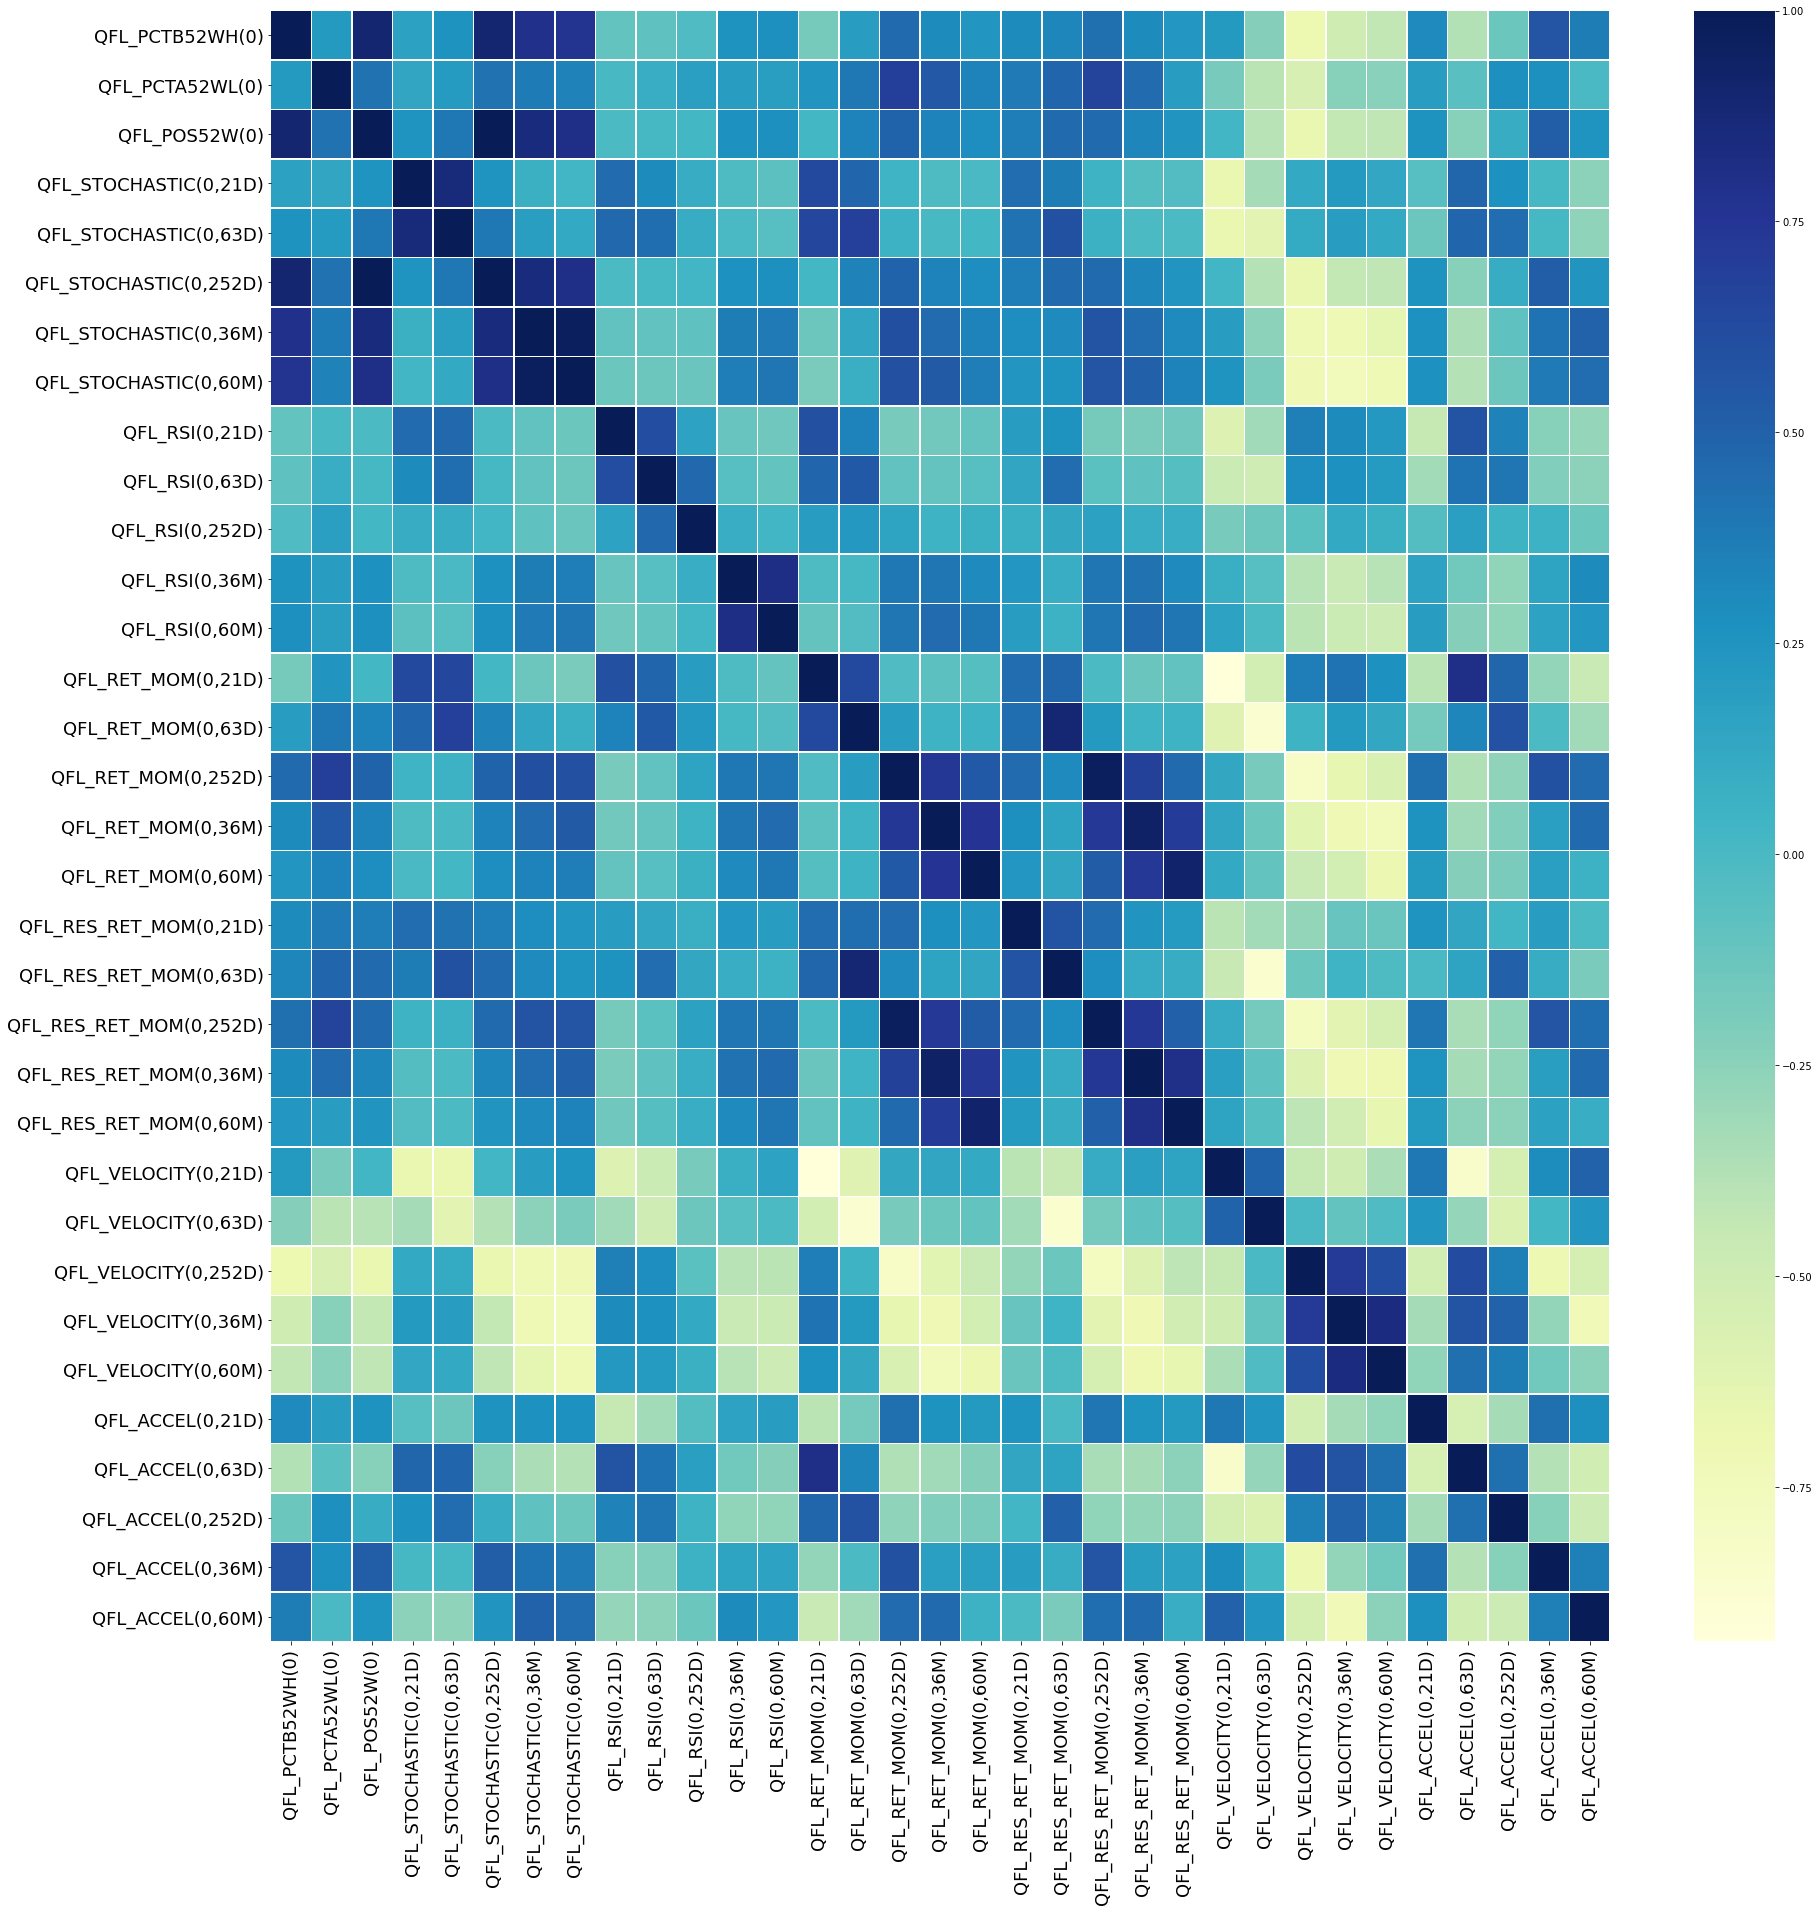

In [56]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

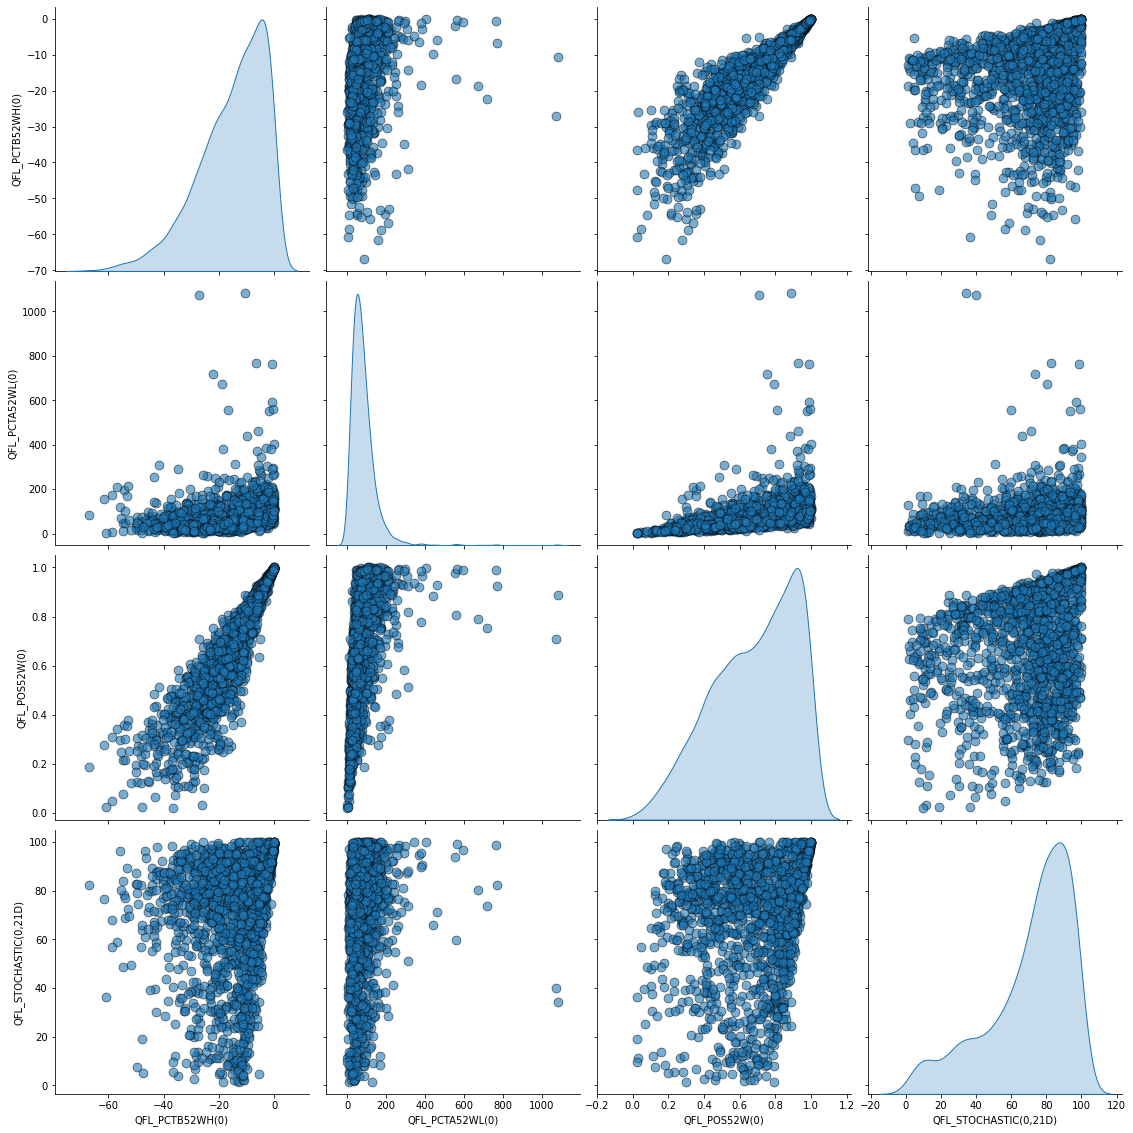

In [20]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [21]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)"
0,-13.719374,123.978190,0.776841,79.959130
1,-8.069223,61.537888,0.812737,50.701797
2,-10.815960,94.832590,0.800537,52.299118
3,-9.091806,102.019550,0.834695,49.025978
4,-3.152817,73.722480,0.928753,73.164770
...,...,...,...,...
1595,-25.854110,65.226340,0.530988,71.041670
1596,-36.538464,1.315784,0.022059,9.677419
1597,-29.515617,40.396750,0.407273,82.467540
1598,-60.721443,4.255319,0.025723,36.363636


In [22]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
QFL_PCTB52WH(0),1598,"[-66.88, 0.0]",-15.38,145.32,-0.97,0.67
QFL_PCTA52WL(0),1598,"[1.15, 1082.27]",81.75,5919.78,5.5,51.42
QFL_POS52W(0),1598,"[0.02, 1.0]",0.68,0.05,-0.53,-0.66
"QFL_STOCHASTIC(0,21D)",1598,"[1.41, 100.0]",70.52,576.98,-1.05,0.28
"QFL_STOCHASTIC(0,63D)",1596,"[1.71, 100.0]",69.74,579.94,-0.91,-0.11
"QFL_STOCHASTIC(0,252D)",1592,"[2.21, 100.0]",68.12,538.87,-0.52,-0.65
"QFL_STOCHASTIC(0,36M)",1551,"[1.07, 100.0]",60.98,694.67,-0.26,-1.08
"QFL_STOCHASTIC(0,60M)",1517,"[0.85, 100.0]",61.6,738.89,-0.32,-1.09
"QFL_RSI(0,21D)",1598,"[23.51, 87.63]",58.41,91.25,-0.29,-0.19
"QFL_RSI(0,63D)",1596,"[32.64, 68.71]",52.33,26.25,-0.09,0.07


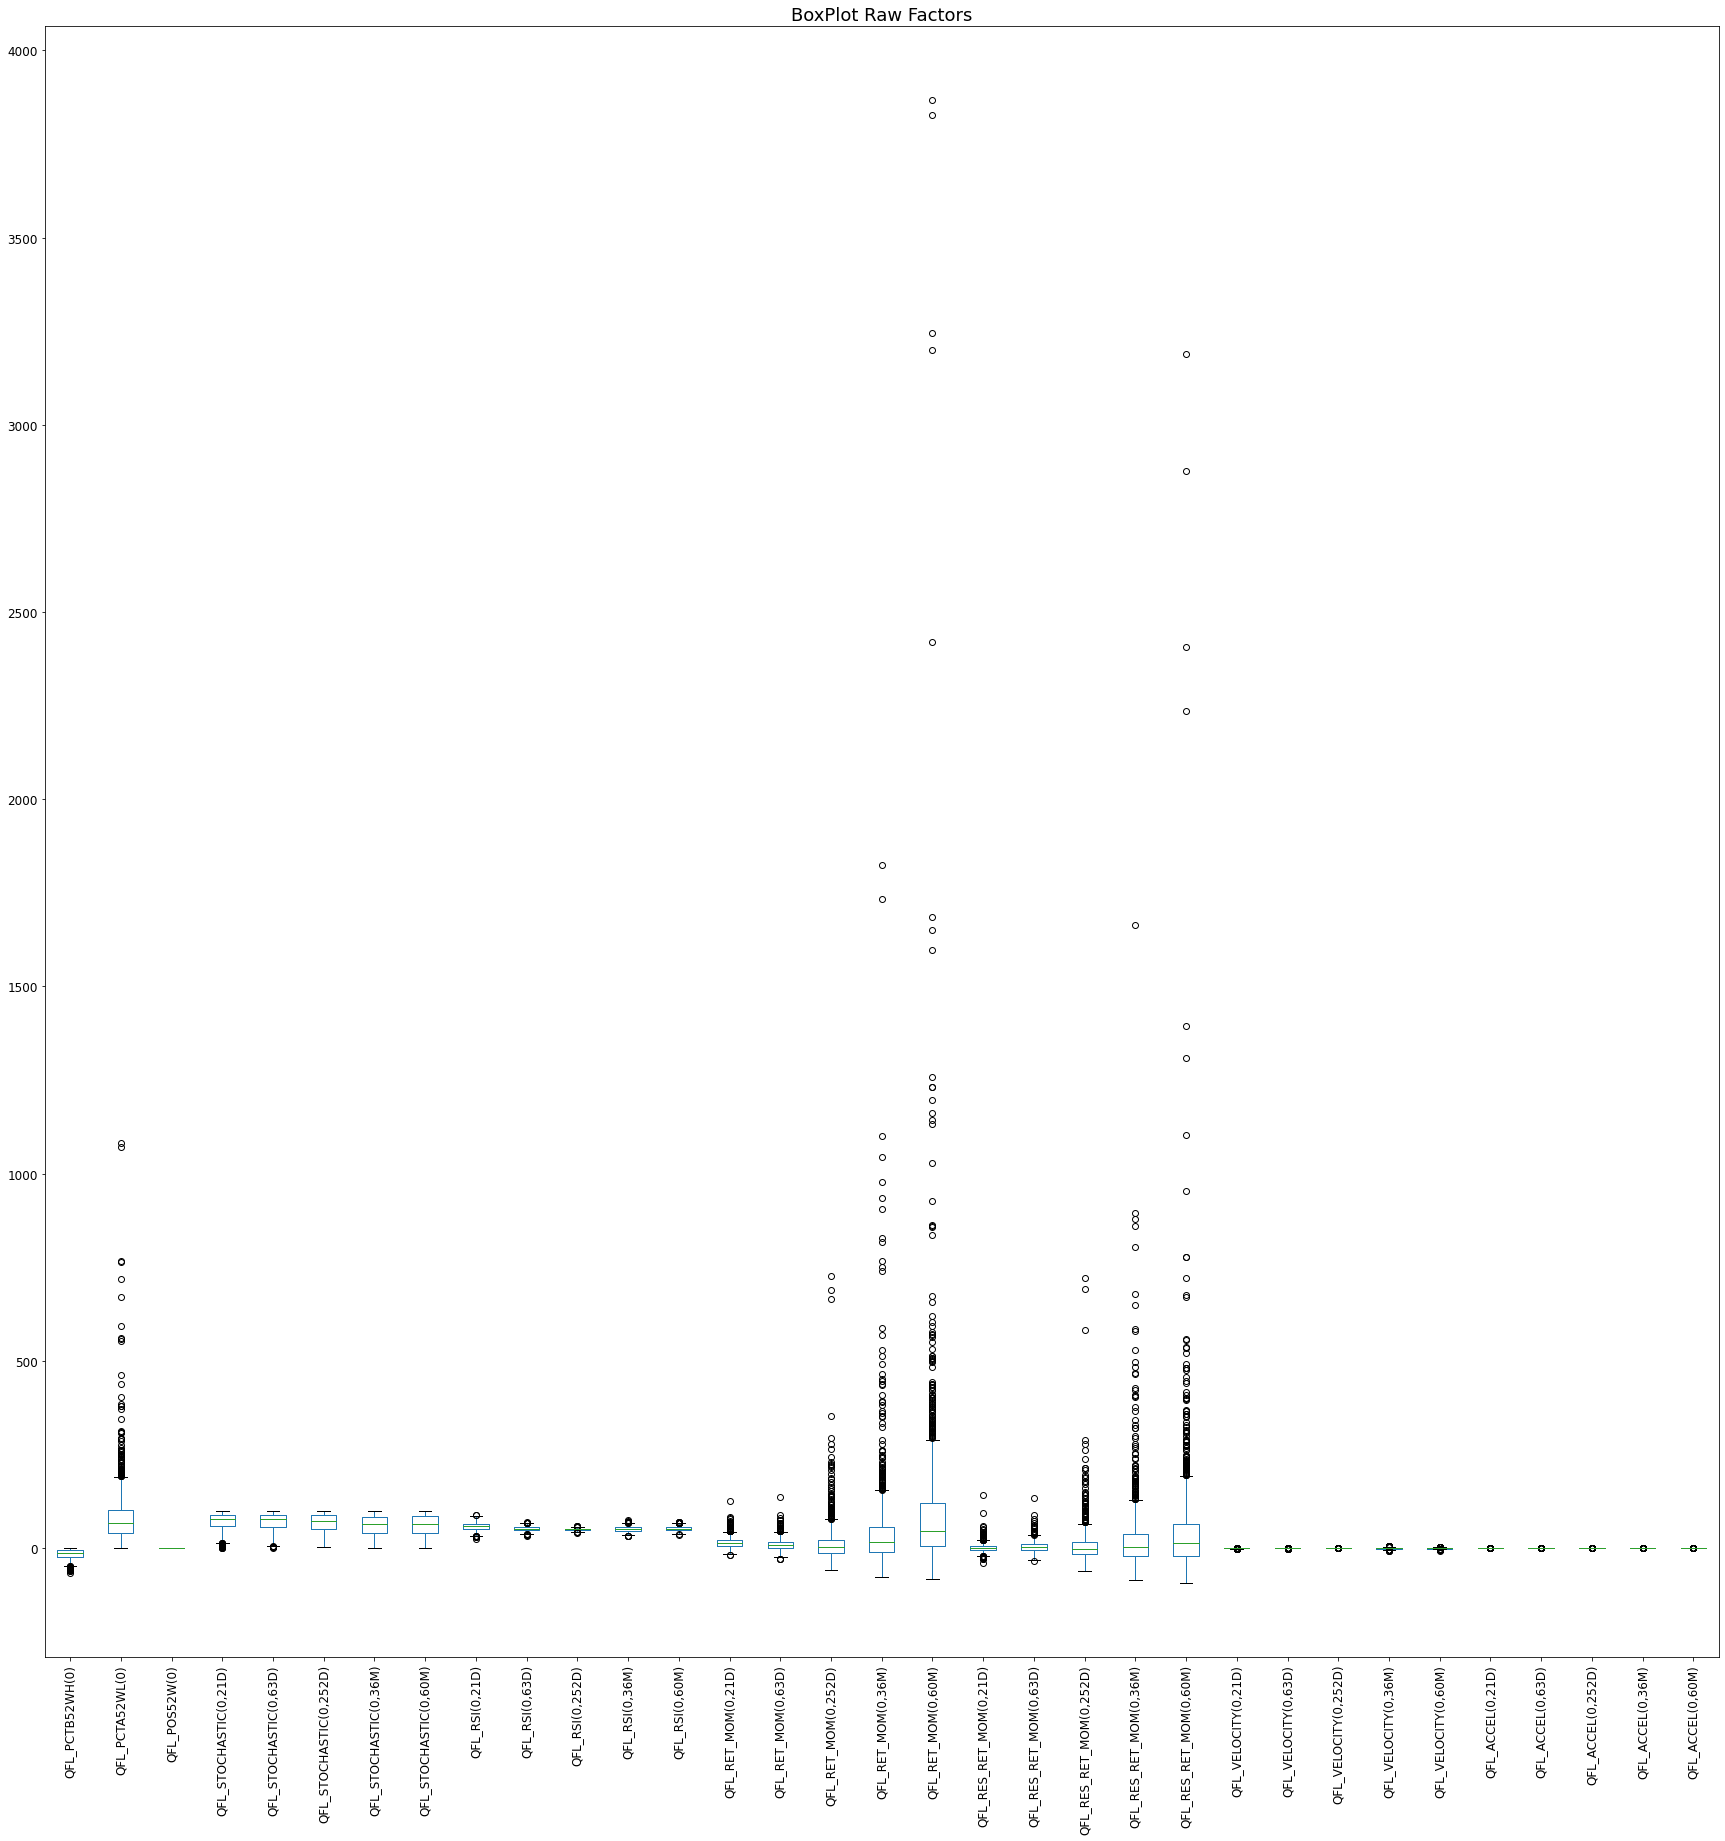

In [23]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [24]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)"
count,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.552000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.552000e+03,1.517000e+03
mean,-2.961058e-16,3.954562e-16,6.491817e-16,-3.254802e-15,5.999100e-16,5.336044e-15,2.457236e-15,-2.011868e-15,1.445958e-14,4.980422e-15,1.369703e-14,1.117446e-14,8.329262e-15,-3.553964e-15,2.635041e-16,5.473706e-16,-6.562914e-16,-1.594345e-16,1.432591e-16,6.118748e-16,-6.011383e-17,-3.969173e-16,-2.399384e-16,6.461248e-16,2.237141e-16,-5.288902e-16,-1.814843e-16,-1.050870e-15,8.489203e-16,8.348933e-16,-1.109526e-16,1.763337e-16,-1.624705e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.271779e+00,-1.047598e+00,-2.832497e+00,-2.877019e+00,-2.824916e+00,-2.839597e+00,-2.273139e+00,-2.234813e+00,-3.653365e+00,-3.843263e+00,-3.969906e+00,-3.093509e+00,-3.306708e+00,-2.541051e+00,-2.643692e+00,-1.445393e+00,-9.883579e-01,-7.335273e-01,-3.910896e+00,-2.715614e+00,-1.487255e+00,-1.139870e+00,-7.878145e-01,-4.829958e+00,-5.157082e+00,-5.895913e+00,-4.315062e+00,-5.129704e+00,-5.084325e+00,-3.809352e+00,-3.579526e+00,-3.717352e+00,-7.647523e+00
25%,-5.895788e-01,-5.317559e-01,-7.554808e-01,-4.916808e-01,-5.999634e-01,-7.502363e-01,-8.036481e-01,-7.920976e-01,-6.679672e-01,-6.639926e-01,-7.065569e-01,-6.662712e-01,-6.828270e-01,-6.841309e-01,-6.873832e-01,-4.844226e-01,-4.305614e-01,-3.795907e-01,-5.830202e-01,-6.527071e-01,-4.813285e-01,-4.610509e-01,-3.900997e-01,-5.780358e-01,-6.082624e-01,-5.633807e-01,-6.218118e-01,-5.738849e-01,-5.355319e-01,-6.634426e-01,-6.596304e-01,-5.787170e-01,-5.673115e-01
50%,2.070053e-01,-1.988454e-01,1.570573e-01,2.898161e-01,3.078261e-01,1.501444e-01,9.220636e-02,1.562340e-01,7.024134e-02,1.840331e-02,-1.460119e-02,-6.781539e-02,-3.723693e-02,-1.318061e-01,-8.868625e-02,-1.774625e-01,-2.007031e-01,-2.098407e-01,-6.511415e-02,-1.151159e-01,-1.551124e-01,-2.057676e-01,-1.929876e-01,5.099582e-02,2.994762e-02,5.090369e-02,1.018924e-02,9.477155e-02,4.105334e-04,-5.851074e-02,-4.318917e-02,-6.037563e-02,4.981080e-02
75%,8.170141e-01,2.500213e-01,8.718195e-01,7.717021e-01,7.891278e-01,8.705808e-01,8.924974e-01,9.174346e-01,7.161028e-01,6.816706e-01,6.687493e-01,6.256885e-01,6.544827e-01,4.920861e-01,5.565702e-01,2.602440e-01,1.364747e-01,8.770907e-02,4.272978e-01,5.459019e-01,2.526012e-01,1.790276e-01,8.930834e-02,6.835724e-01,6.648567e-01,6.046499e-01,6.574716e-01,6.023571e-01,5.706767e-01,5.555022e-01,6.333824e-01,5.779998e-01,6.507124e-01
max,1.275945e+00,1.300386e+01,1.370583e+00,1.227418e+00,1.256745e+00,1.373210e+00,1.480302e+00,1.412851e+00,3.058344e+00,3.197235e+00,3.737462e+00,3.778225e+00,3.516968e+00,8.5

In [25]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)"
0,1.275945,13.003860,1.370583,1.227418,1.256745,1.373210,1.480302,1.412851,3.058344,3.197235,3.737462,3.778225,3.516968,8.539478,8.766192,14.975724,15.192627,15.381244,13.475597,9.376202,15.828715,17.437637,17.548486,3.425518,3.856882,3.706458,3.780887,3.956467,6.209474,4.107777,4.252557,6.193992,3.799478
1,1.275945,12.872508,1.370583,1.227418,1.256745,1.373210,1.480302,1.412851,3.056091,3.044356,3.430163,3.118722,3.507738,5.231600,5.492846,14.165038,14.417208,15.217341,8.830281,6.118580,15.136916,9.264772,15.795090,3.129183,3.470333,3.641314,3.460137,3.481935,4.666910,3.987440,3.736192,4.455954,3.753325
2,1.275945,8.909176,1.370583,1.227418,1.256745,1.373210,1.480302,1.412851,2.768921,2.946767,3.240582,3.045152,3.217075,5.119175,4.913134,13.673583,9.029949,12.847847,5.485572,5.384402,12.751362,9.089176,13.169346,3.088816,3.072038,3.616779,3.321890,3.415719,4.316440,3.693498,3.285425,3.844400,3.456884
3,1.275945,8.866119,1.370583,1.227418,1.256745,1.373210,1.479167,1.409081,2.593464,2.893238,2.971170,2.986653,3.205722,4.747843,4.535061,7.132138,8.550388,12.657522,5.367844,5.017839,6.270506,8.896634,12.222017,3.010262,2.721772,2.958877,3.042044,3.065991,4.184927,3.567123,3.200065,3.840340,3.183442
4,1.273686,8.267660,1.369122,1.227418,1.256745,1.371746,1.475756,1.408797,2.202903,2.758025,2.794056,2.972023,3.021906,4.438118,4.523802,5.921755,7.986133,9.472693,4.822756,4.540470,6.042178,8.314659,7.524387,2.870975,2.701669,2.916898,3.002006,3.031449,3.926935,3.471544,3.150027,3.667370,3.026376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-3.761162,-1.031184,-2.816750,-2.863162,-2.824916,NaN,NaN,NaN,-3.001177,-3.843263,NaN,NaN,NaN,-2.320718,-2.643692,NaN,NaN,NaN,-2.976613,-2.715614,NaN,NaN,NaN,-4.031303,-5.157082,NaN,NaN,NaN,-3.748593,-3.809352,NaN,NaN,NaN
1596,-3.828445,-1.045467,-2.819461,-2.874469,NaN,NaN,NaN,NaN,-3.050175,NaN,NaN,NaN,NaN,-2.455650,NaN,NaN,NaN,NaN,-3.037758,NaN,NaN,NaN,NaN,-4.487568,NaN,NaN,NaN,NaN,-4.886637,NaN,NaN,NaN,NaN
1597,-4.271779,-1.047598,-2.832497,-2.877019,NaN,NaN,NaN,NaN,-3.653365,NaN,NaN,NaN,NaN,-2.541051,NaN,NaN,NaN,NaN,-3.910896,NaN,NaN,NaN,NaN,-4.829958,NaN,NaN,NaN,NaN,-5.084325,NaN,NaN,NaN,NaN
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)"
0,-4.271779,-1.047598,-2.832497,-2.877019,-2.824916,-2.839597,-2.273139,-2.234813,-3.653365,-3.843263,-3.969906,-3.093509,-3.306708,-2.541051,-2.643692,-1.445393,-0.988358,-0.733527,-3.910896,-2.715614,-1.487255,-1.139870,-0.787814,-4.829958,-5.157082,-5.895913,-4.315062,-5.129704,-5.084325,-3.809352,-3.579526,-3.717352,-7.647523
1,-3.828445,-1.045467,-2.819461,-2.874469,-2.813520,-2.826529,-2.254543,-2.232342,-3.050175,-3.566292,-3.146779,-2.975459,-2.735453,-2.455650,-2.606458,-1.406082,-0.969699,-0.725625,-3.037758,-2.434399,-1.459309,-1.130165,-0.778086,-4.487568,-4.787278,-5.083866,-4.214603,-4.831072,-4.886637,-3.508155,-3.577003,-3.407958,-5.519960
2,-3.761162,-1.031184,-2.816750,-2.863162,-2.803470,-2.819363,-2.248513,-2.229234,-3.001177,-3.371711,-3.019805,-2.927089,-2.569629,-2.320718,-2.586374,-1.398834,-0.935624,-0.711161,-2.976613,-2.374691,-1.449987,-1.085893,-0.765847,-4.031303,-4.589747,-5.077319,-4.014116,-4.521794,-3.748593,-3.392028,-3.532011,-3.268571,-3.808306
3,-3.599291,-1.011540,-2.792613,-2.846024,-2.782730,-2.799619,-2.242830,-2.223183,-2.918290,-3.256288,-2.850394,-2.723928,-2.553737,-2.285326,-2.314932,-1.379424,-0.902982,-0.680554,-2.689316,-2.257287,-1.394443,-1.081445,-0.761497,-4.031297,-3.822616,-4.703086,-3.667996,-4.494083,-3.663195,-3.112950,-3.163660,-3.259191,-3.612739
4,-3.572078,-1.007262,-2.719218,-2.841988,-2.761580,-2.726054,-2.199775,-2.159253,-2.811466,-2.792188,-2.757975,-2.519408,-2.547580,-2.190499,-2.286062,-1.307145,-0.878227,-0.678669,-2.660937,-2.253435,-1.352575,-1.070207,-0.750577,-4.025237,-3.671214,-4.694229,-3.535761,-4.001180,-3.577808,-2.918189,-2.952993,-2.923244,-3.576900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1.275945,8.909176,1.370583,1.227418,1.256745,NaN,NaN,NaN,2.768921,3.197235,NaN,NaN,NaN,5.119175,8.766192,NaN,NaN,NaN,5.485572,9.376202,NaN,NaN,NaN,3.088816,3.856882,NaN,NaN,NaN,4.316440,4.107777,NaN,NaN,NaN
1596,1.275945,12.872508,1.370583,1.227418,NaN,NaN,NaN,NaN,3.056091,NaN,NaN,NaN,NaN,5.231600,NaN,NaN,NaN,NaN,8.830281,NaN,NaN,NaN,NaN,3.129183,NaN,NaN,NaN,NaN,4.666910,NaN,NaN,NaN,NaN
1597,1.275945,13.003860,1.370583,1.227418,NaN,NaN,NaN,NaN,3.058344,NaN,NaN,NaN,NaN,8.539478,NaN,NaN,NaN,NaN,13.475597,NaN,NaN,NaN,NaN,3.425518,NaN,NaN,NaN,NaN,6.209474,NaN,NaN,NaN,NaN
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


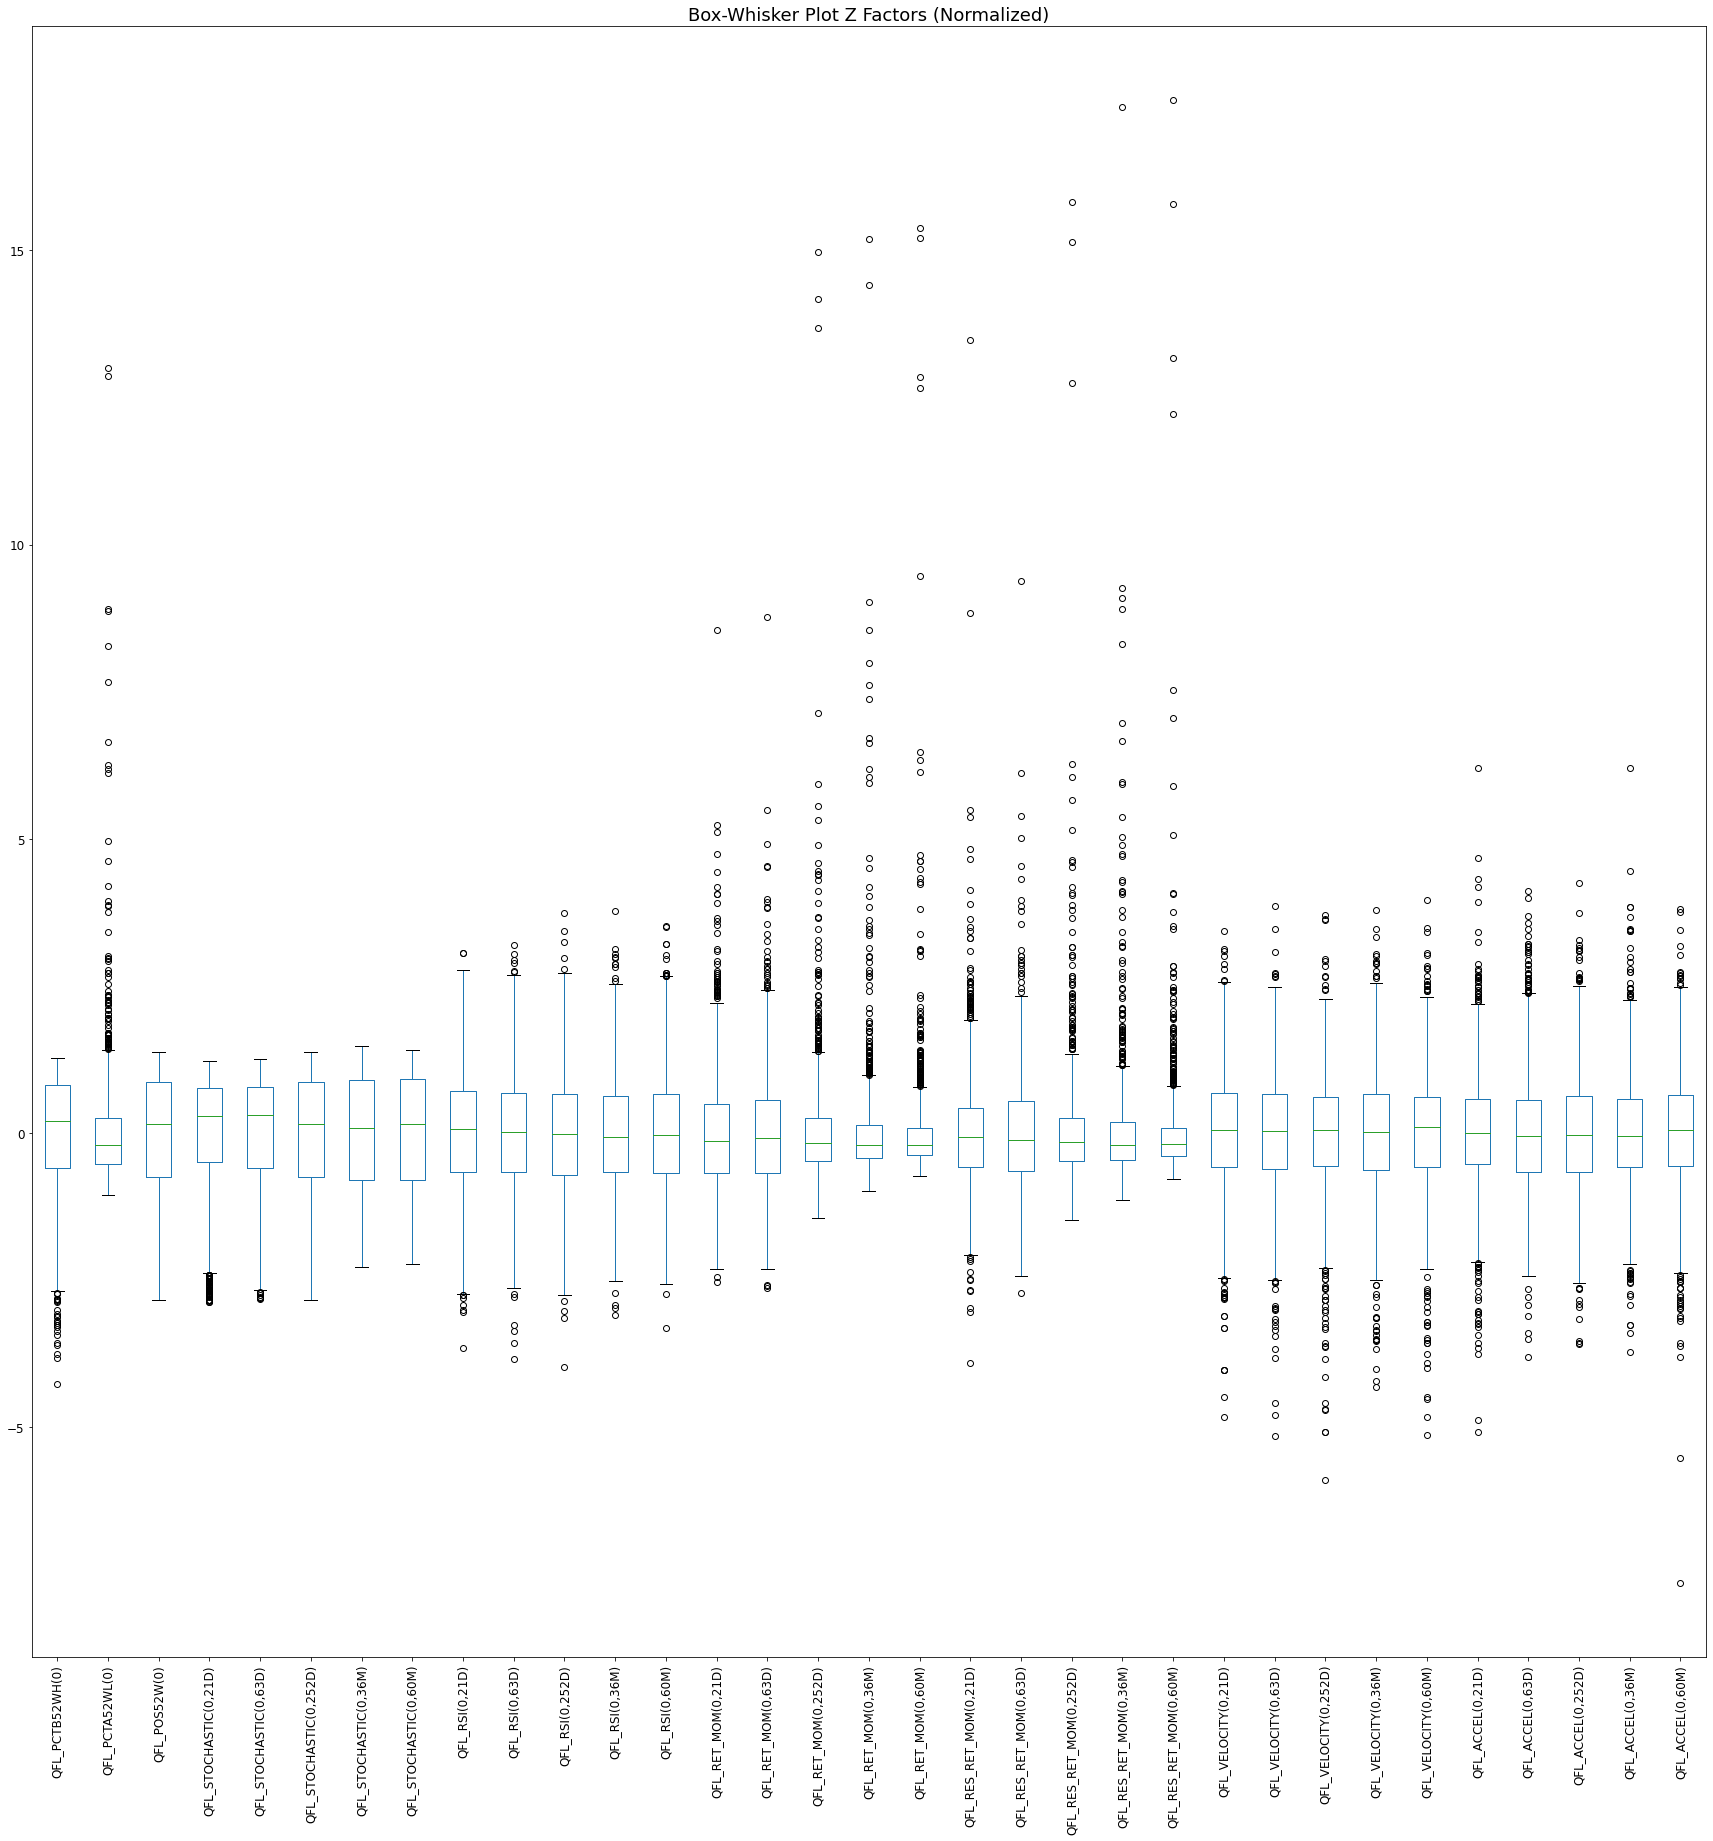

In [27]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [28]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)",MFR
0,-4.271779,-1.047598,-2.832497,-2.877019,-2.824916,-2.839597,-2.273139,-2.234813,-3.653365,-3.843263,-3.969906,-3.093509,-3.306708,-2.541051,-2.643692,-1.445393,-0.988358,-0.733527,-3.910896,-2.715614,-1.487255,-1.139870,-0.787814,-4.829958,-5.157082,-5.895913,-4.315062,-5.129704,-5.084325,-3.809352,-3.579526,-3.717352,-7.647523,-3.231133
1,-3.828445,-1.045467,-2.819461,-2.874469,-2.813520,-2.826529,-2.254543,-2.232342,-3.050175,-3.566292,-3.146779,-2.975459,-2.735453,-2.455650,-2.606458,-1.406082,-0.969699,-0.725625,-3.037758,-2.434399,-1.459309,-1.130165,-0.778086,-4.487568,-4.787278,-5.083866,-4.214603,-4.831072,-4.886637,-3.508155,-3.577003,-3.407958,-5.519960,-2.953826
2,-3.761162,-1.031184,-2.816750,-2.863162,-2.803470,-2.819363,-2.248513,-2.229234,-3.001177,-3.371711,-3.019805,-2.927089,-2.569629,-2.320718,-2.586374,-1.398834,-0.935624,-0.711161,-2.976613,-2.374691,-1.449987,-1.085893,-0.765847,-4.031303,-4.589747,-5.077319,-4.014116,-4.521794,-3.748593,-3.392028,-3.532011,-3.268571,-3.808306,-2.789448
3,-3.599291,-1.011540,-2.792613,-2.846024,-2.782730,-2.799619,-2.242830,-2.223183,-2.918290,-3.256288,-2.850394,-2.723928,-2.553737,-2.285326,-2.314932,-1.379424,-0.902982,-0.680554,-2.689316,-2.257287,-1.394443,-1.081445,-0.761497,-4.031297,-3.822616,-4.703086,-3.667996,-4.494083,-3.663195,-3.112950,-3.163660,-3.259191,-3.612739,-2.662984
4,-3.572078,-1.007262,-2.719218,-2.841988,-2.761580,-2.726054,-2.199775,-2.159253,-2.811466,-2.792188,-2.757975,-2.519408,-2.547580,-2.190499,-2.286062,-1.307145,-0.878227,-0.678669,-2.660937,-2.253435,-1.352575,-1.070207,-0.750577,-4.025237,-3.671214,-4.694229,-3.535761,-4.001180,-3.577808,-2.918189,-2.952993,-2.923244,-3.576900,-2.567300


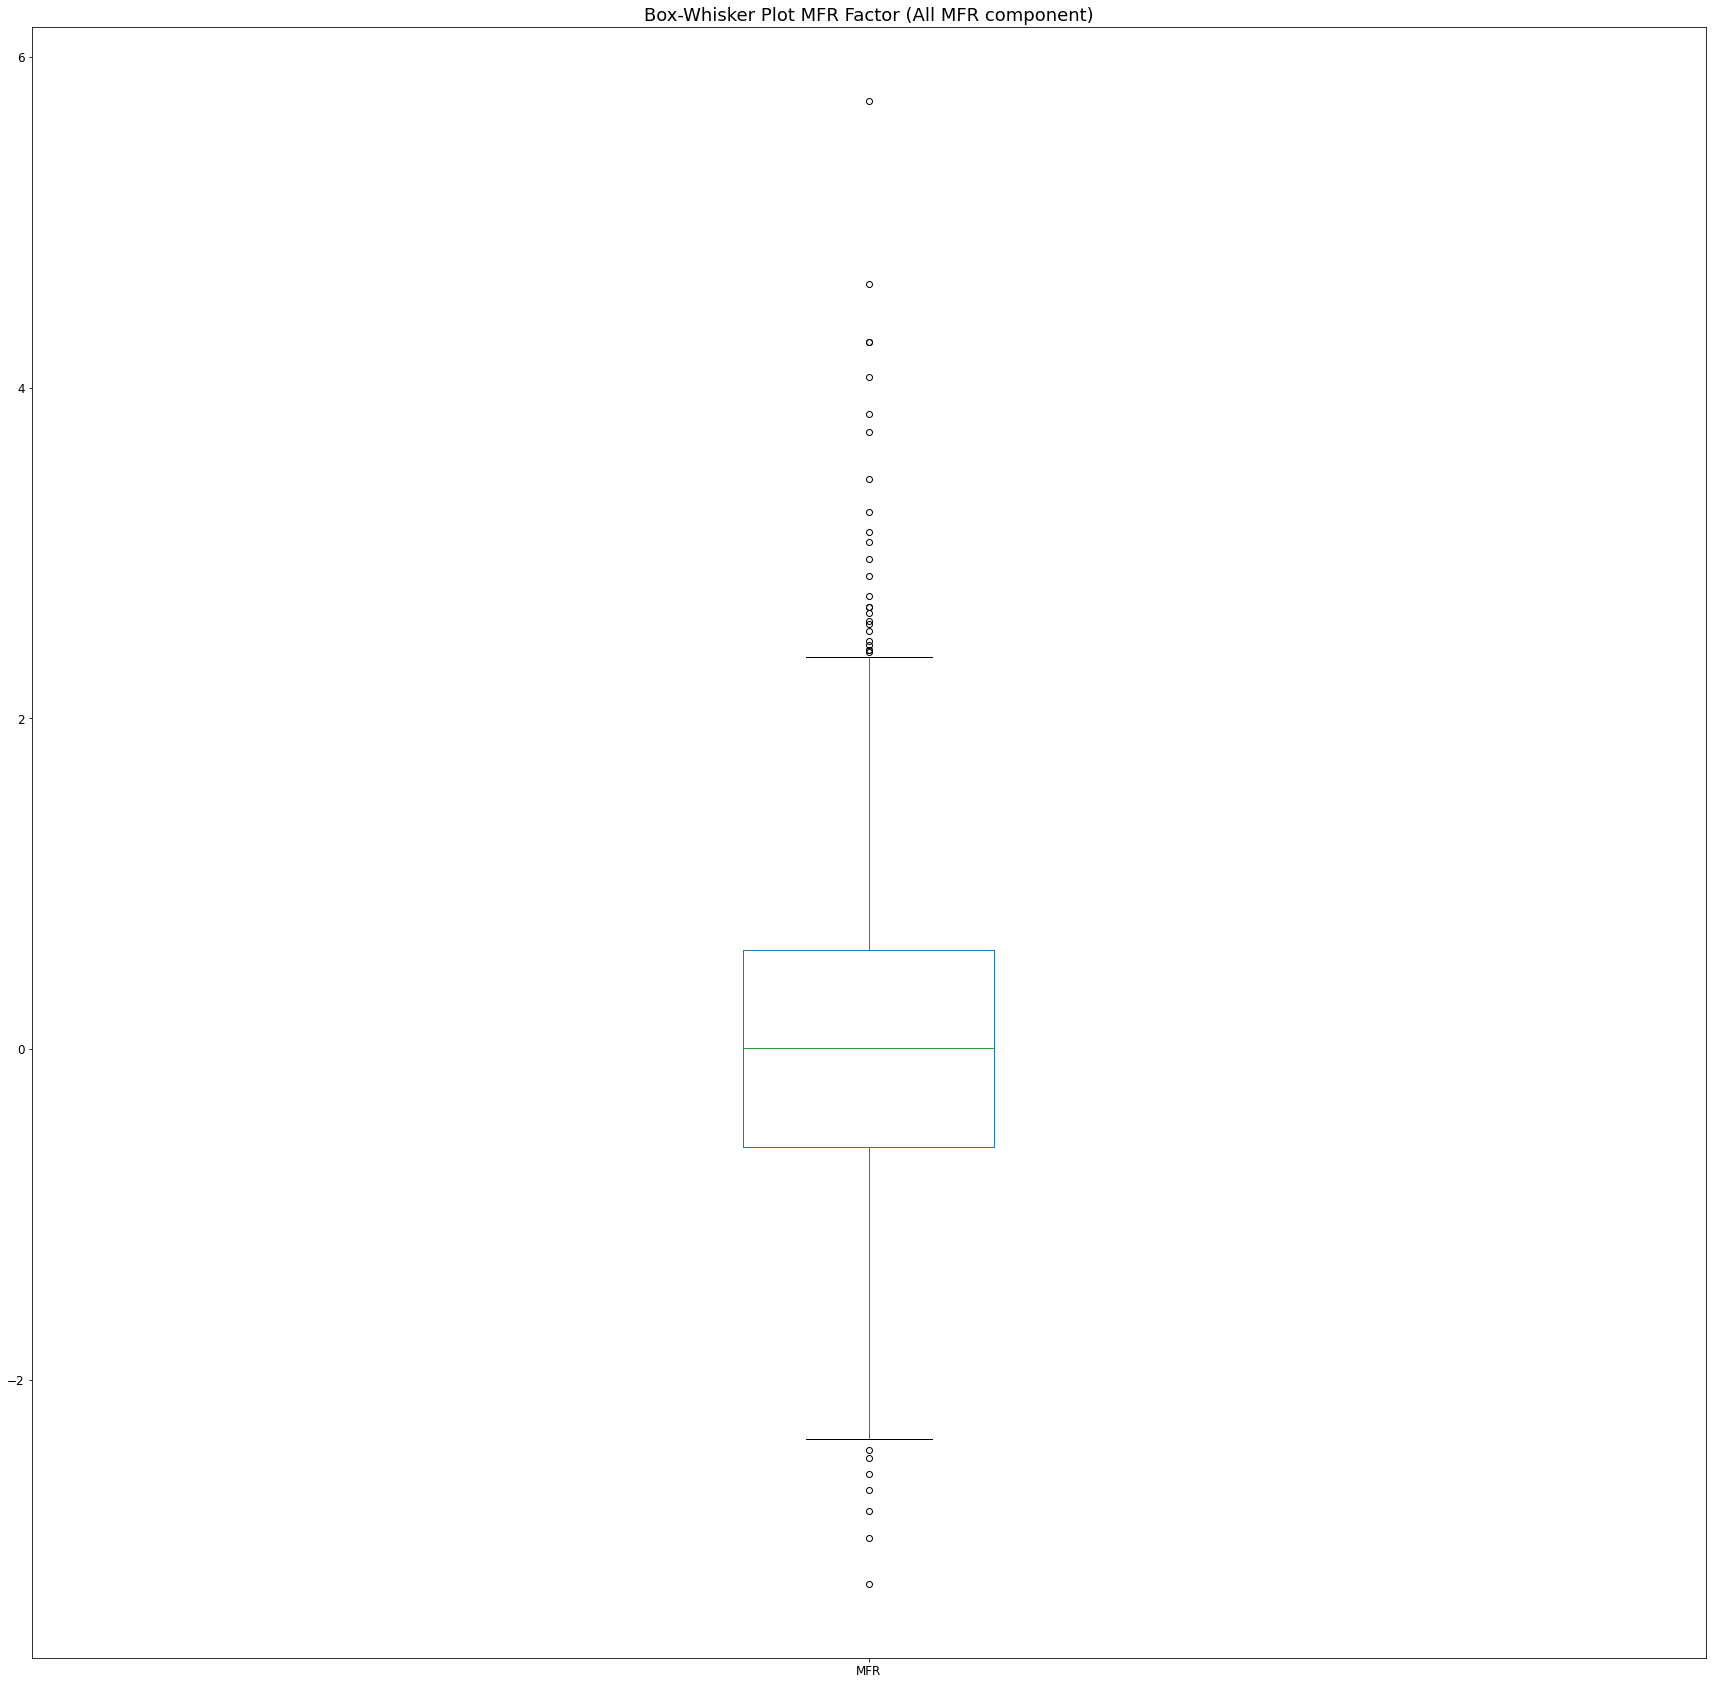

In [29]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

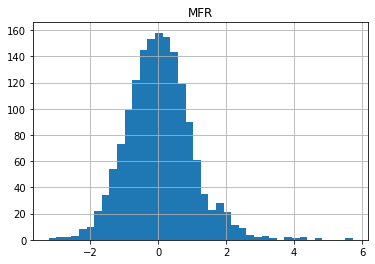

In [30]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


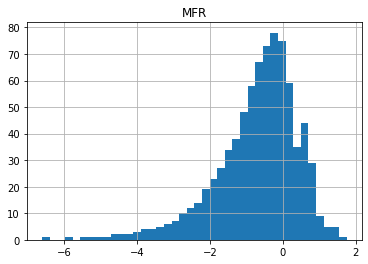

In [32]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [33]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)"
0,-13.719374,4.820106,-0.252520,4.381516,3.822716,4.352651,4.400948,4.426359,4.134064,3.835830,3.931768,4.045182,4.024627,9.548962,-9.242762,76.611664,182.391620,314.184300,0.303888,-10.394615,53.577350,95.770200,112.126396,-0.130529,-0.045580,-0.262566,-2.795292,-2.318713,-0.094575,0.002134,0.001860,0.251615,0.040650
1,-8.069223,4.119653,-0.207348,3.925961,3.885171,4.397822,4.473365,4.497959,4.028290,3.745981,3.862834,4.024221,4.027506,6.005824,-7.347292,41.059780,161.102550,309.990840,-6.721079,-8.521212,22.464966,101.224045,164.919750,0.005108,-0.061650,-0.150090,-2.652300,-2.503783,-0.039345,-0.001657,-0.000232,0.062859,0.022840
2,-10.815960,4.552113,-0.222473,3.956980,3.775108,4.382697,4.432870,4.471851,3.962690,3.855157,3.924780,3.986030,4.005147,4.343998,-10.290670,79.968540,169.219470,376.540300,-5.603766,-11.446655,62.181057,92.404090,154.642140,-0.019399,0.006574,-0.288269,-2.031178,-2.654821,0.014448,-0.002831,-0.001121,0.143003,-0.020558
3,-9.091806,4.625164,-0.180689,3.892350,4.011345,4.424482,4.439716,4.467450,4.139148,3.937093,3.882676,3.913399,3.924575,5.267763,-8.439672,40.772556,56.321262,165.704160,-9.056783,-9.611583,23.270452,5.231512,39.348995,0.058973,-0.084950,-0.177061,-1.233387,-1.236259,-0.013041,0.005937,0.001693,0.181186,-0.002062
4,-3.152817,4.300308,-0.073912,4.292714,4.455170,4.531258,4.535179,4.554269,4.082858,3.792960,3.823878,3.917937,3.872050,8.619928,1.878166,30.399109,72.383270,137.104770,-4.046965,0.616348,14.559817,23.846626,32.536460,-0.212334,-0.325848,-0.096825,-1.153151,-1.318660,-0.060791,0.018752,0.001740,0.098658,-0.003541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-25.854110,4.177863,-0.633016,4.263267,4.341135,3.972155,3.829799,3.665804,4.254818,4.099940,3.944084,4.037637,4.063631,15.119516,16.528273,-15.997314,1.327825,2.729321,-4.062665,13.374400,-15.928674,-4.749912,-21.423077,-0.706679,-0.300669,0.153405,1.133499,0.622744,-0.189781,0.024009,0.004721,-0.212300,-0.044614
1596,-36.538464,0.274433,-3.814035,2.269795,1.966113,0.791127,0.446287,-0.089231,3.733467,3.821449,3.975073,3.640207,3.715778,-4.545456,-11.753726,-31.444757,-28.908354,-48.727272,-10.446191,-16.267746,-32.790410,-31.757046,-54.859543,0.396366,0.234907,0.135430,1.057966,0.811768,-0.041330,-0.004822,0.000226,-0.017875,-0.010490
1597,-29.515617,3.698749,-0.898272,4.412405,4.419922,3.706898,3.645204,3.601719,4.222273,4.019503,3.854679,3.957662,3.939062,32.332207,17.535364,-20.933592,-13.735735,1.429307,1.902819,13.342810,-22.122175,-20.132530,-24.711334,-1.295614,-0.169618,0.191657,1.211271,0.492564,-0.230336,0.040483,0.003922,-0.204754,-0.061393
1598,-60.721443,1.448170,-3.660370,3.593569,2.315164,0.984168,0.069886,-0.165514,3.959567,3.928256,3.941980,3.743483,3.923526,-2.970296,-23.437500,-58.562366,-70.388960,-76.422760,-13.599271,-34.226590,-60.454560,-73.810265,-83.129814,0.150811,0.546427,0.335890,4.405320,1.648773,-0.009096,0.010276,0.001121,-0.227648,-0.186098


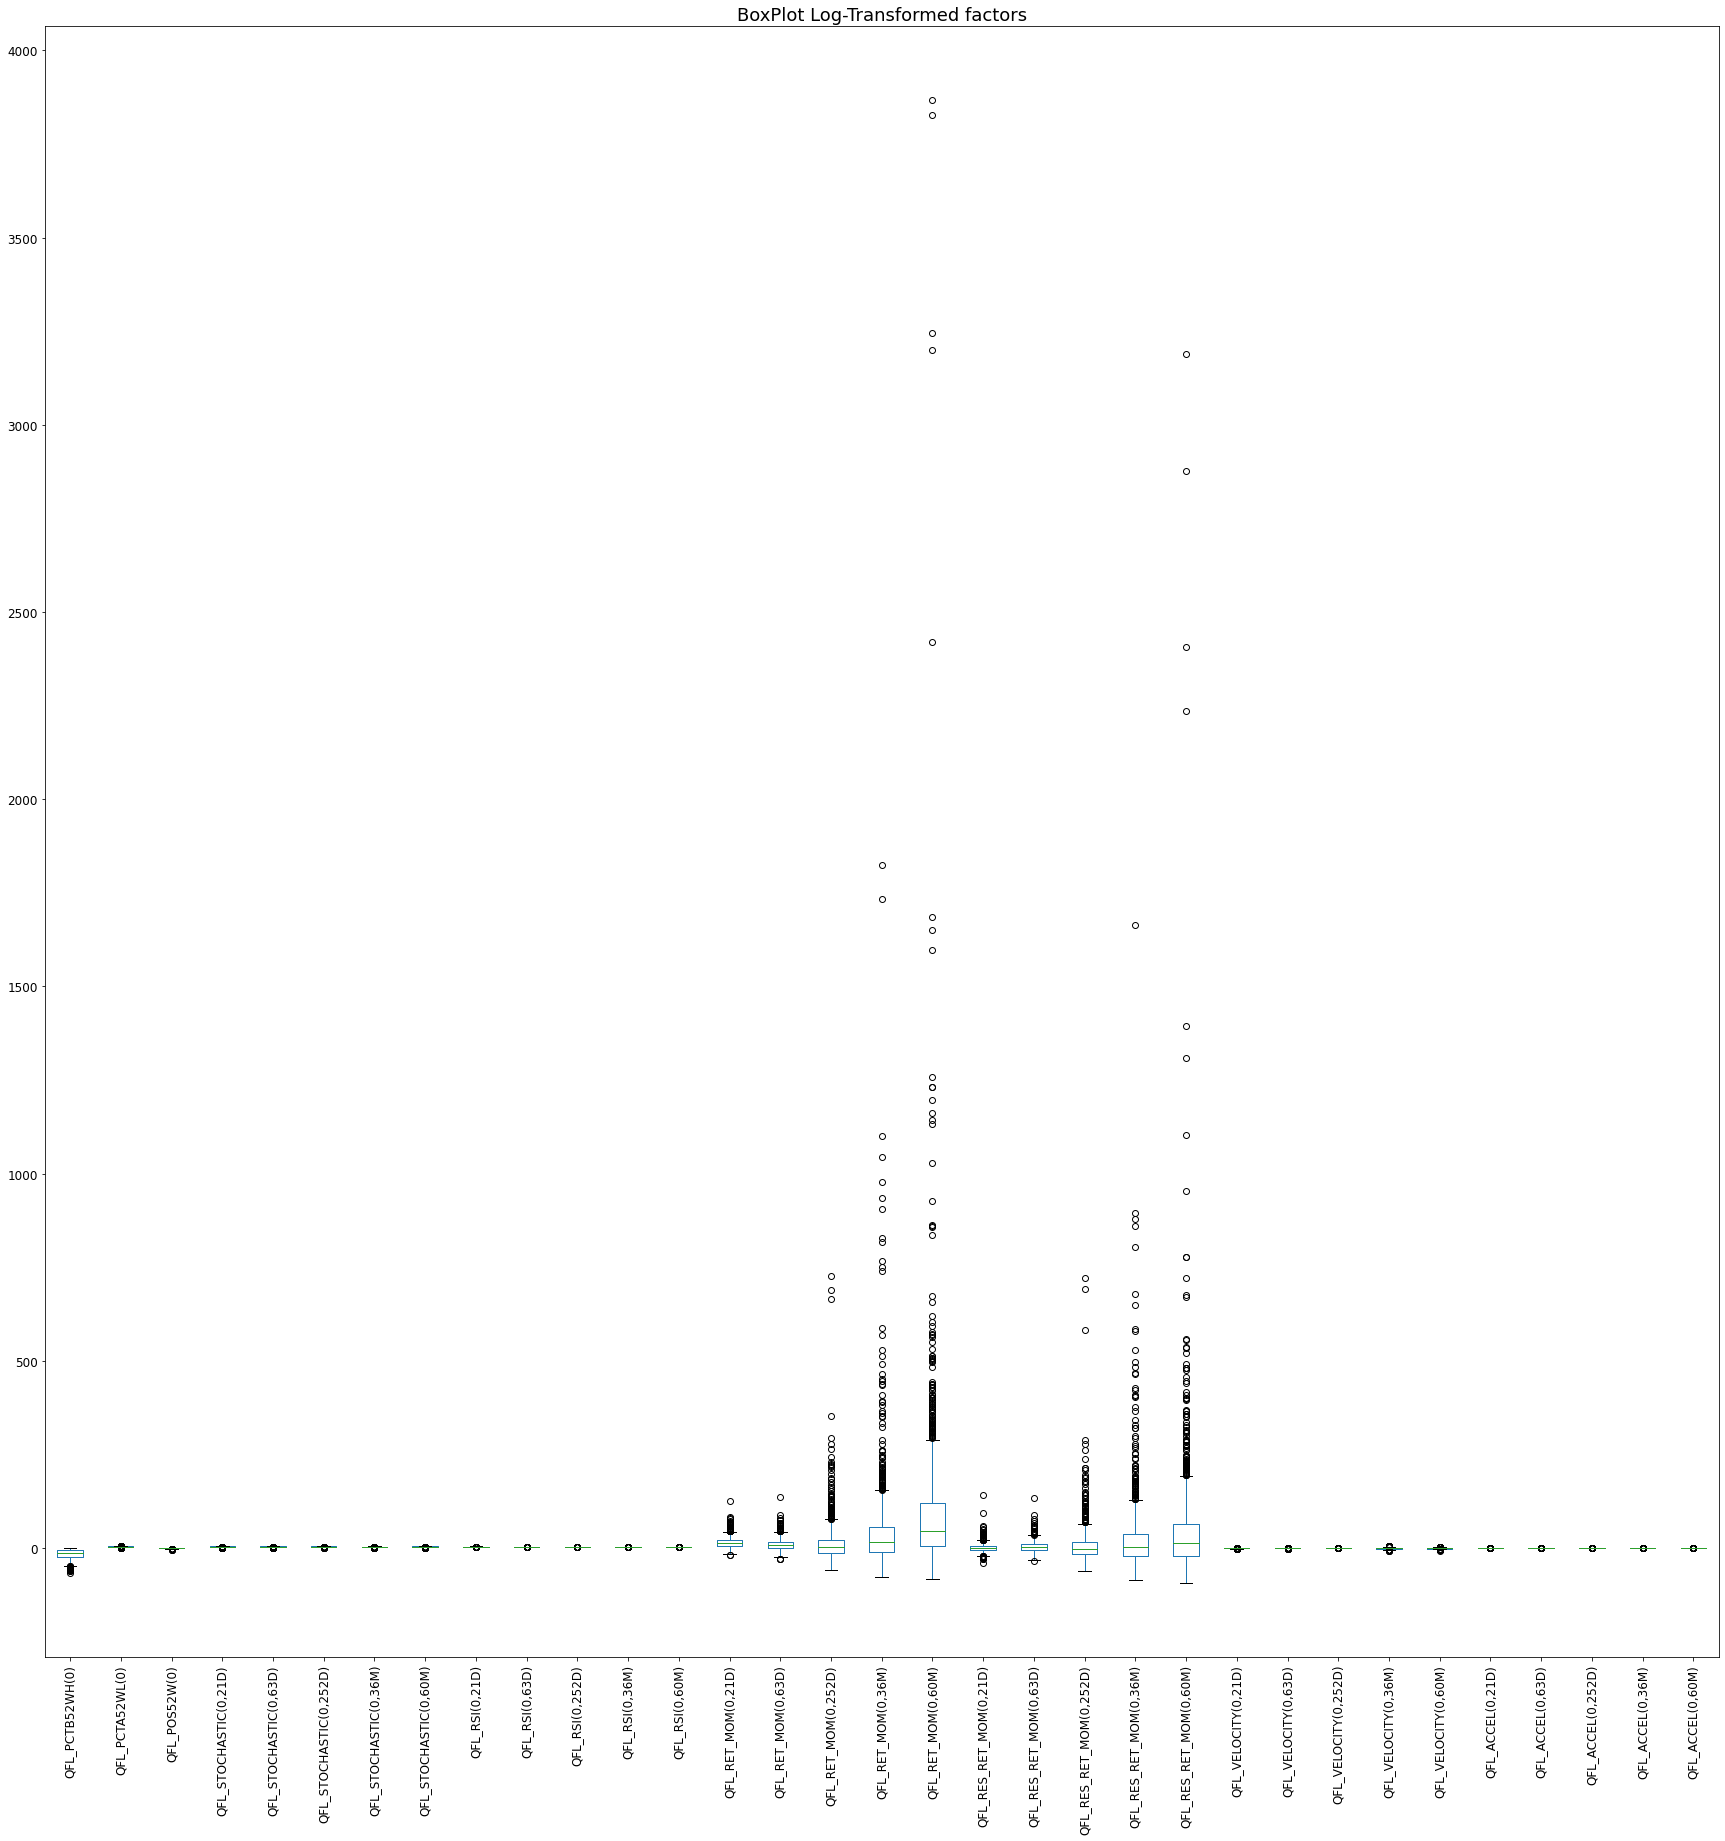

In [34]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [35]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)",MFR
0,0.137864,0.908850,0.460150,0.403937,-0.575383,0.460169,0.707734,0.711764,0.466274,-1.172427,0.211173,0.924191,0.779257,-0.373021,-1.302087,1.377150,1.215568,0.883068,-0.126748,-0.994271,1.067538,0.784126,0.357124,0.660305,0.441940,-1.736444,-1.740811,-1.613129,-0.167125,-0.486083,-0.268573,1.732738,1.246488,0.163070
1,0.606568,-0.010353,0.556148,-0.370107,-0.462077,0.556477,0.827073,0.823165,-0.143106,-2.074374,-1.231965,0.758163,0.807888,-0.643306,-1.170693,0.634798,1.034396,0.865952,-0.807028,-0.858959,0.380658,0.842031,0.652039,0.889839,0.370546,-0.981222,-1.653178,-1.773674,0.375939,-0.678409,-1.148242,0.446934,0.973949,-0.048610
2,0.378715,0.557164,0.524005,-0.317403,-0.661753,0.524230,0.760340,0.782544,-0.521042,-0.978417,0.064869,0.455671,0.585525,-0.770077,-1.374727,1.447245,1.103471,1.137568,-0.698830,-1.070258,1.257486,0.748387,0.594626,0.848366,0.673643,-1.909027,-1.272522,-1.904696,0.904873,-0.737968,-1.522059,0.992874,0.309847,0.027657
3,0.521741,0.653029,0.612803,-0.427216,-0.233170,0.613317,0.771622,0.775696,0.495565,-0.155905,-0.816572,-0.119608,-0.215747,-0.699608,-1.246417,0.628801,0.142695,0.277059,-1.033211,-0.937714,0.398442,-0.177150,-0.049427,0.980993,0.267031,-1.162319,-0.783594,-0.674123,0.634580,-0.293148,-0.338795,1.252976,0.592884,0.007743
4,1.014406,0.226720,0.839722,0.253052,0.572018,0.840969,0.928938,0.910775,0.171270,-1.602776,-2.047517,-0.083667,-0.738095,-0.443892,-0.531187,0.412195,0.279384,0.160333,-0.548074,-0.198968,0.206134,0.020492,-0.087483,0.521868,-0.803202,-0.623573,-0.734421,-0.745604,0.165065,0.356987,-0.319032,0.690796,0.570251,-0.011094


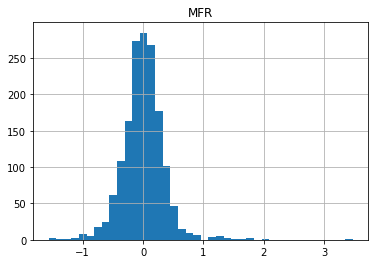

In [36]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [37]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.07
Information Coefficient (P-Value): 0.01


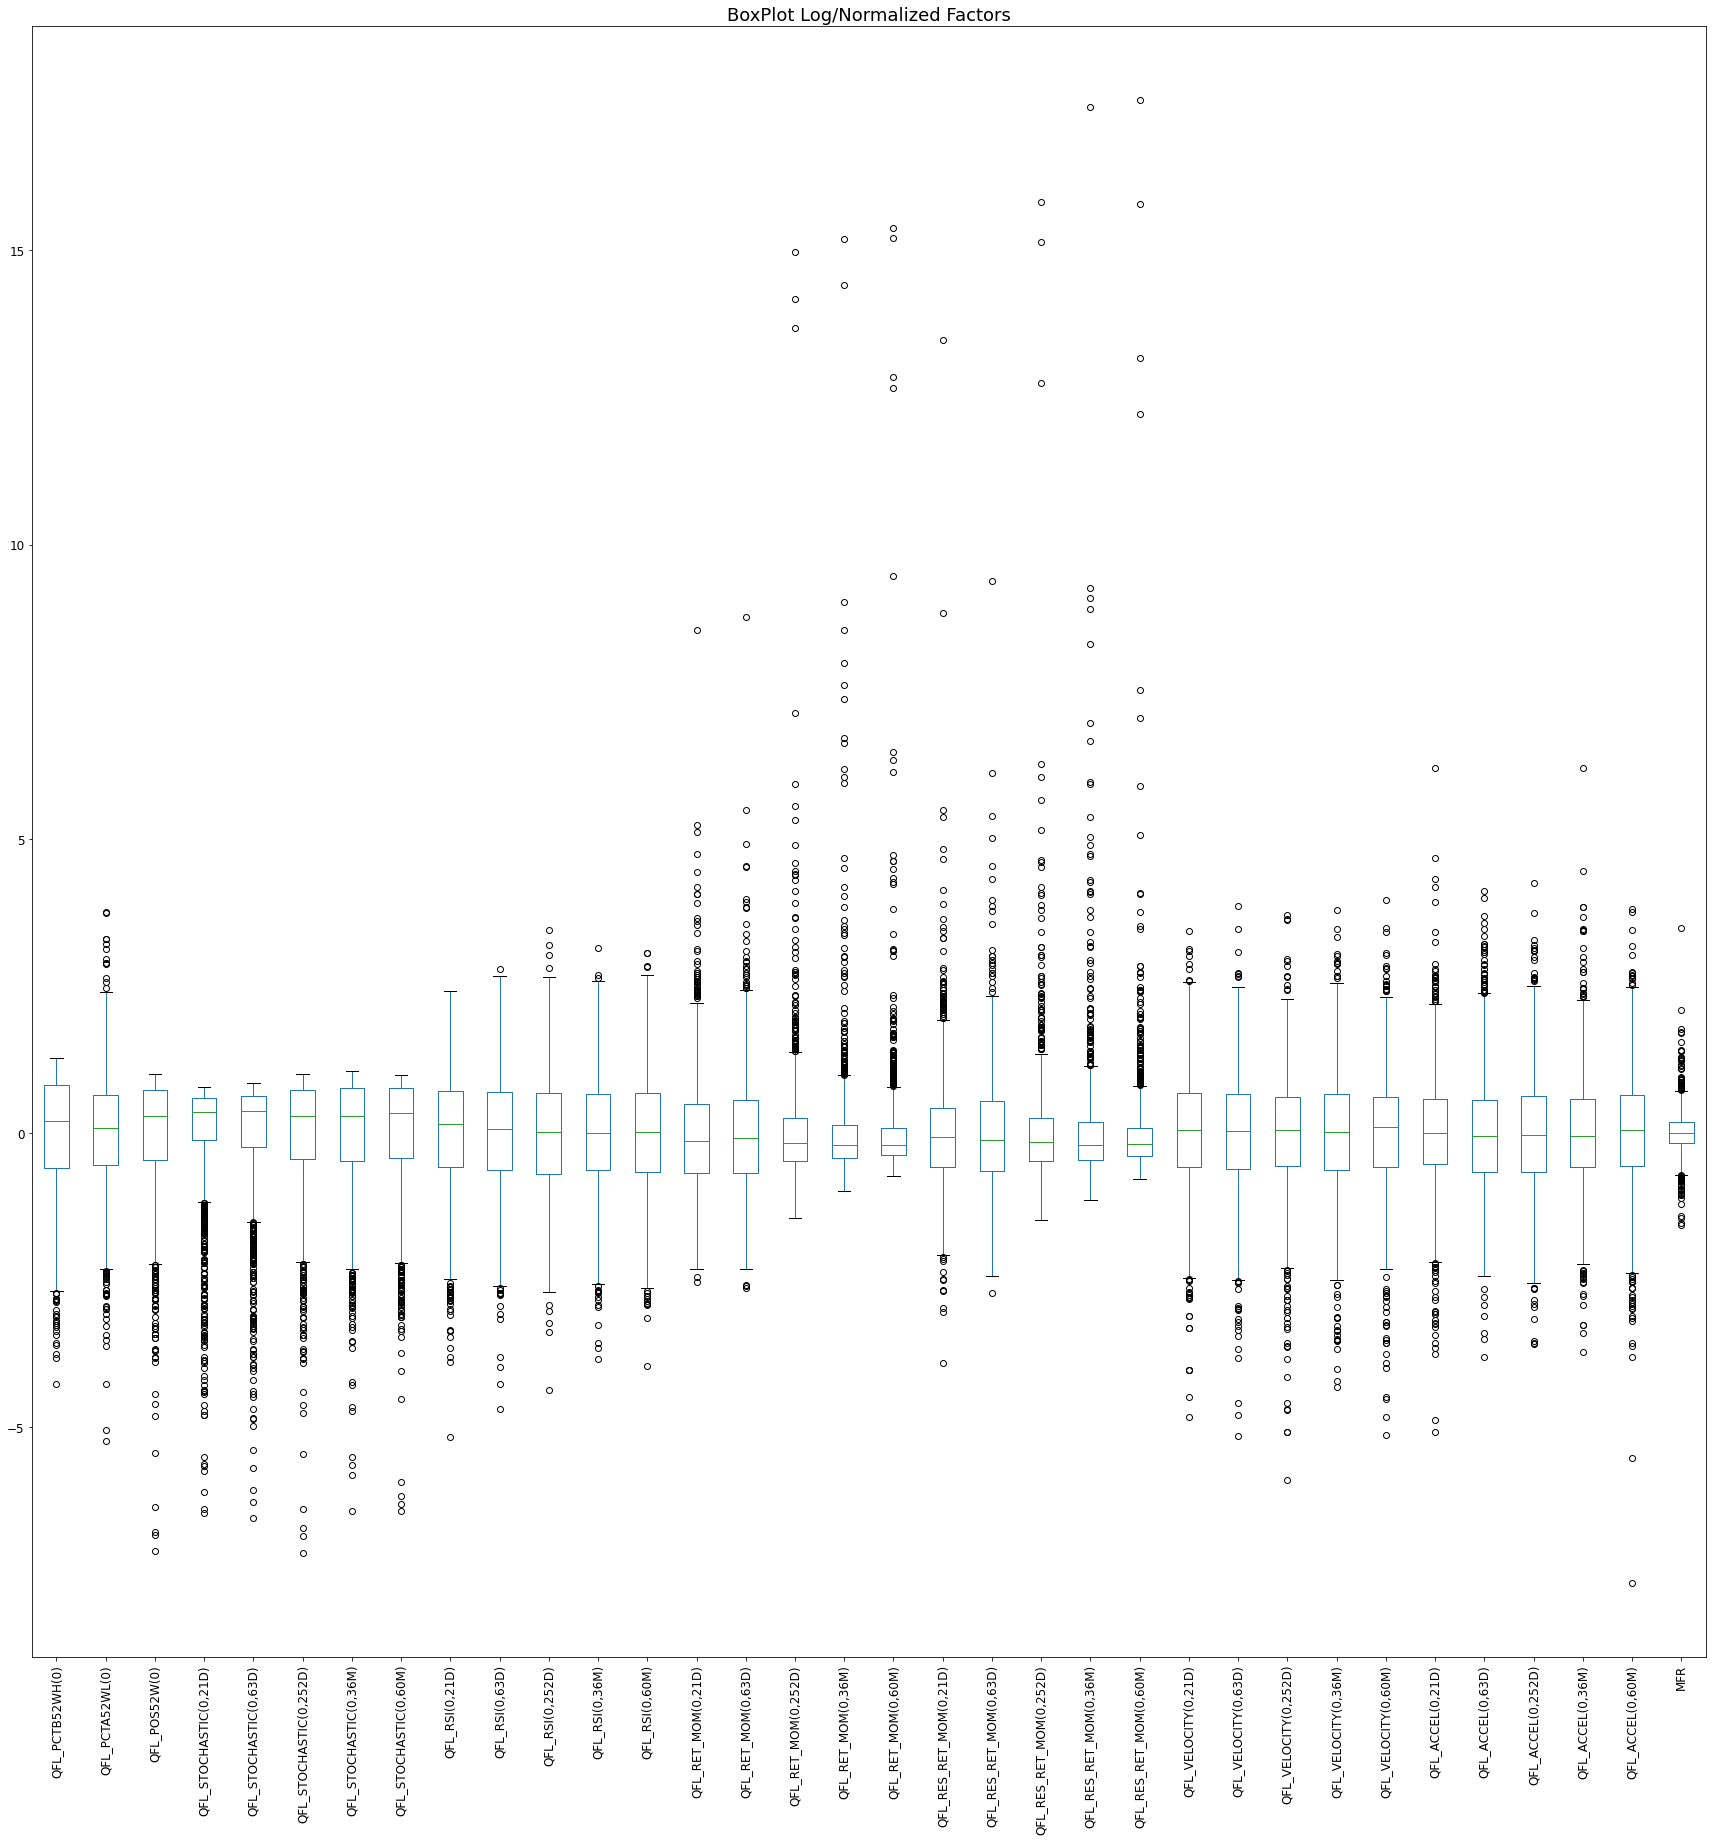

In [38]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [39]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_PCTB52WH(0),QFL_PCTA52WL(0),QFL_POS52W(0),"QFL_STOCHASTIC(0,21D)","QFL_STOCHASTIC(0,63D)","QFL_STOCHASTIC(0,252D)","QFL_STOCHASTIC(0,36M)","QFL_STOCHASTIC(0,60M)","QFL_RSI(0,21D)","QFL_RSI(0,63D)","QFL_RSI(0,252D)","QFL_RSI(0,36M)","QFL_RSI(0,60M)","QFL_RET_MOM(0,21D)","QFL_RET_MOM(0,63D)","QFL_RET_MOM(0,252D)","QFL_RET_MOM(0,36M)","QFL_RET_MOM(0,60M)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,252D)","QFL_RES_RET_MOM(0,36M)","QFL_RES_RET_MOM(0,60M)","QFL_VELOCITY(0,21D)","QFL_VELOCITY(0,63D)","QFL_VELOCITY(0,252D)","QFL_VELOCITY(0,36M)","QFL_VELOCITY(0,60M)","QFL_ACCEL(0,21D)","QFL_ACCEL(0,63D)","QFL_ACCEL(0,252D)","QFL_ACCEL(0,36M)","QFL_ACCEL(0,60M)",ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,-13.719374,123.978190,0.776841,79.959130,45.728226,77.684135,81.52811,83.626340,62.431100,46.331880,50.997080,57.121586,55.959446,9.548962,-9.242762,76.611664,182.391620,314.18430,0.303888,-10.394615,53.577350,95.770200,112.126396,-0.130529,-0.045580,-0.262566,-2.795292,-2.318713,-0.094575,0.002134,0.001860,0.251615,0.040650,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,-8.069223,61.537888,0.812737,50.701797,48.675243,81.273674,87.65116,89.833626,56.164803,42.350544,47.600063,55.936695,56.120780,6.005824,-7.347292,41.059780,161.102550,309.99084,-6.721079,-8.521212,22.464966,101.224045,164.919750,0.005108,-0.061650,-0.150090,-2.652300,-2.503783,-0.039345,-0.001657,-0.000232,0.062859,0.022840,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,-10.815960,94.832590,0.800537,52.299118,43.602207,80.053665,84.17267,87.518560,52.598618,47.236030,50.641930,53.840717,54.879868,4.343998,-10.290670,79.968540,169.219470,376.54030,-5.603766,-11.446655,62.181057,92.404090,154.642140,-0.019399,0.006574,-0.288269,-2.031178,-2.654821,0.014448,-0.002831,-0.001121,0.143003,-0.020558,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,-9.091806,102.019550,0.834695,49.025978,55.221110,83.469530,84.75089,87.134224,62.749317,51.269337,48.553980,50.068855,50.631550,5.267763,-8.439672,40.772556,56.321262,165.70416,-9.056783,-9.611583,23.270452,5.231512,39.348995,0.058973,-0.084950,-0.177061,-1.233387,-1.236259,-0.013041,0.005937,0.001693,0.181186,-0.002062,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,-3.152817,73.722480,0.928753,73.164770,86.070790,92.875280,93.24016,95.037224,59.314760,44.387608,45.781390,50.296570,48.040783,8.619928,1.878166,30.399109,72.383270,137.10477,-4.046965,0.616348,14.559817,23.846626,32.536460,-0.212334,-0.325848,-0.096825,-1.153151,-1.318660,-0.060791,0.018752,0.001740,0.098658,-0.003541,1


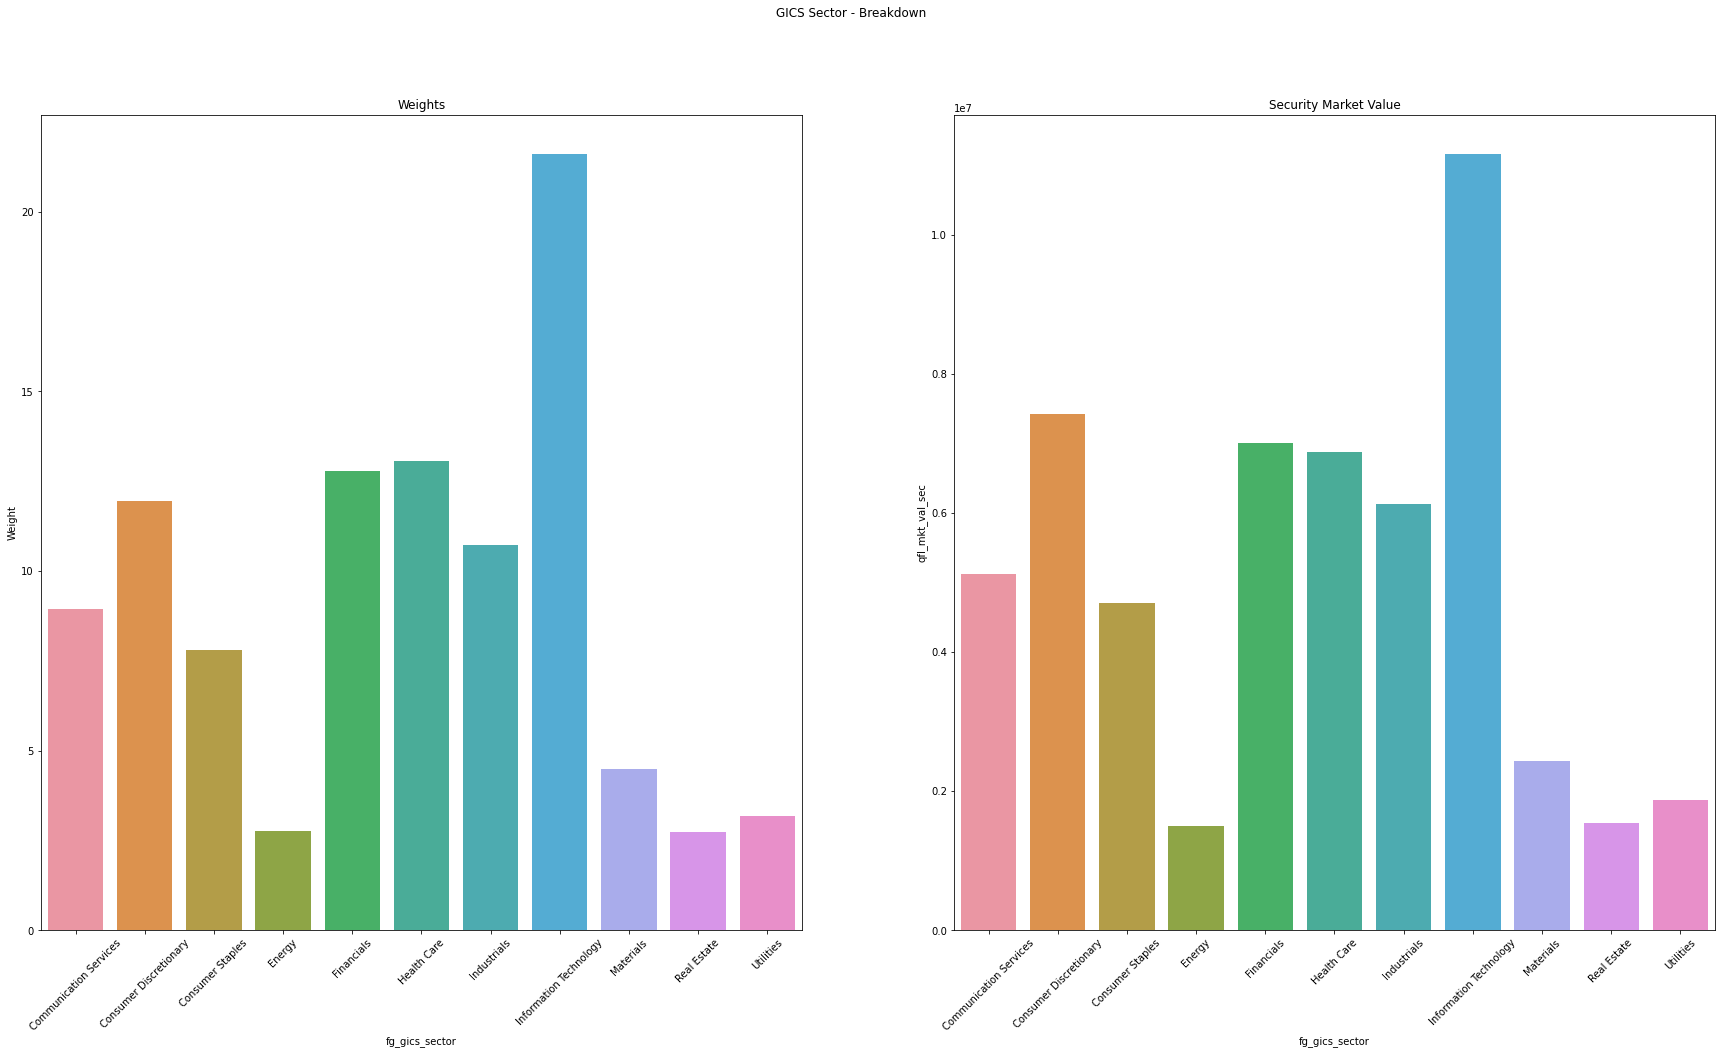

In [40]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

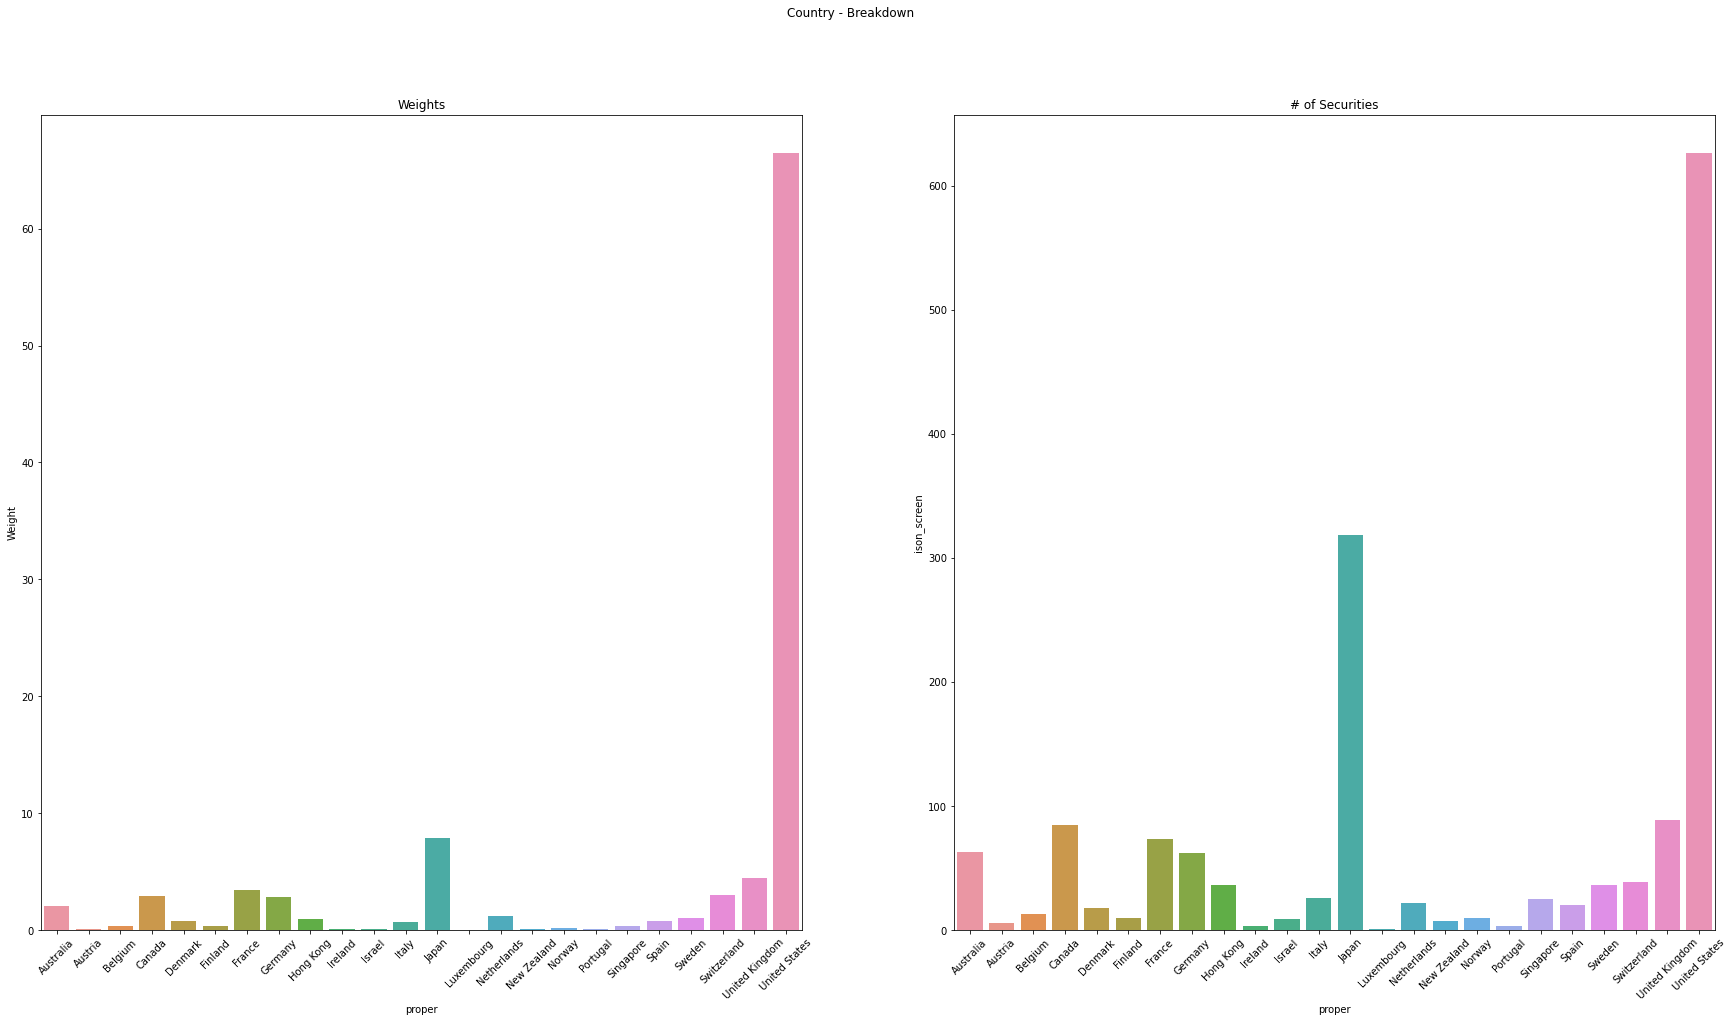

In [41]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

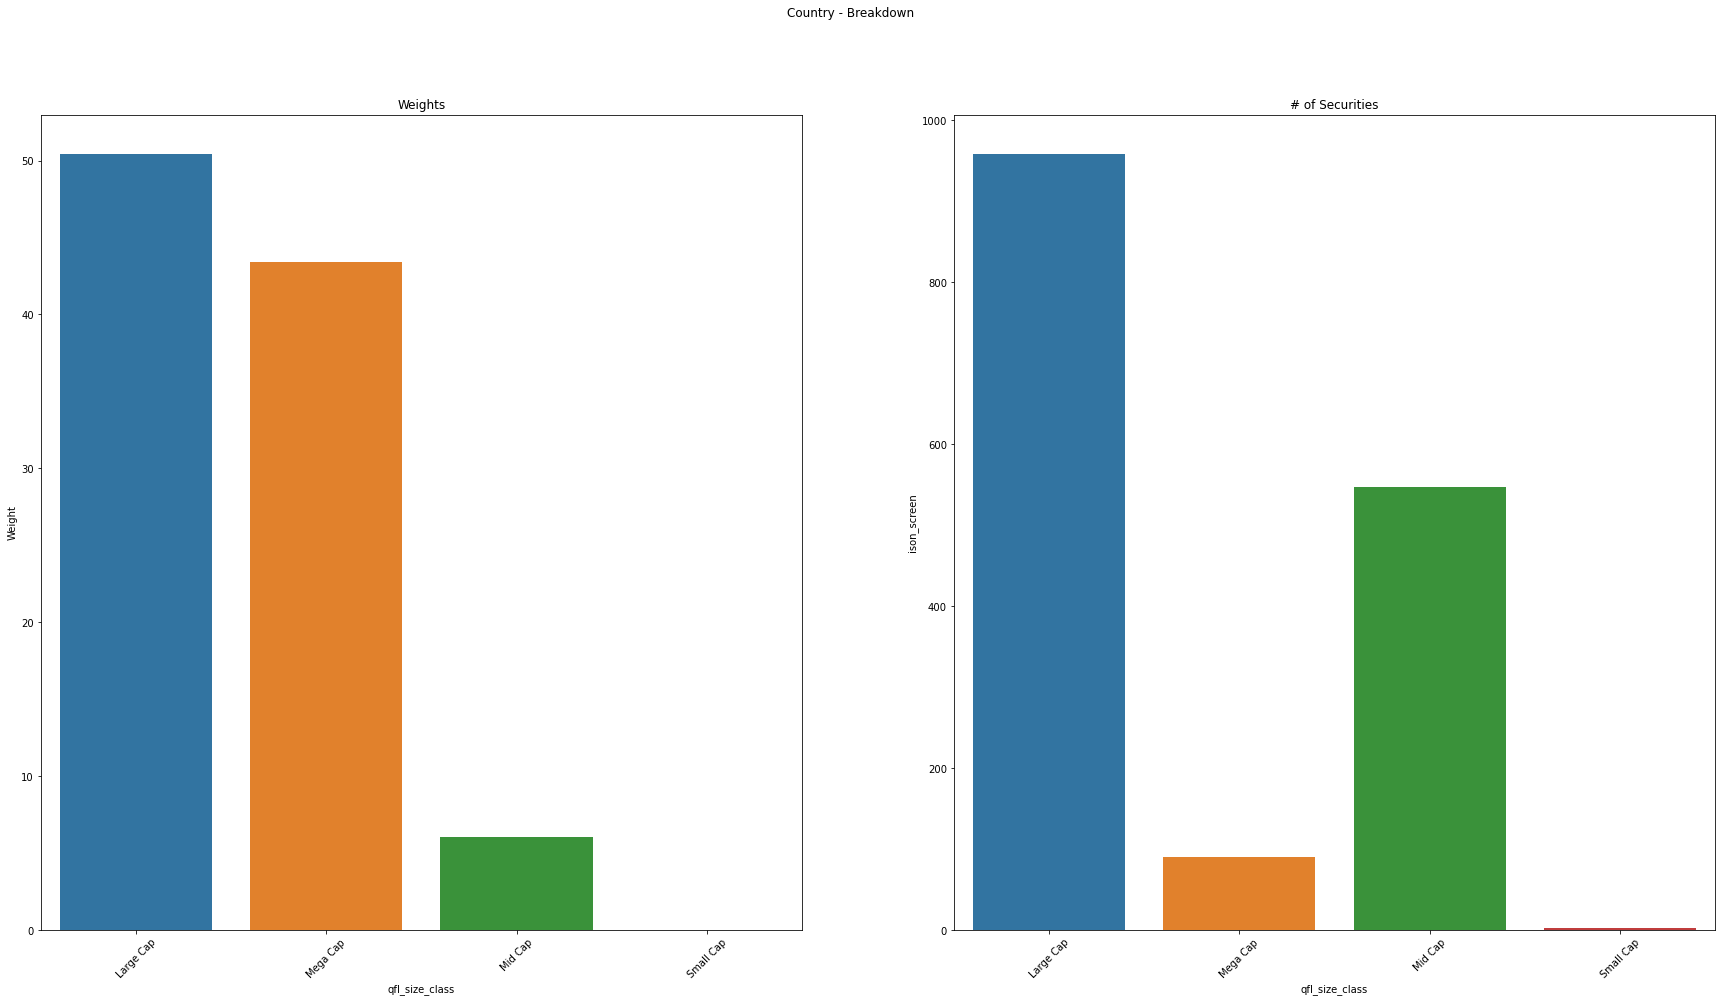

In [42]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [43]:
# Feature Selection

In [44]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [45]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-45-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [46]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False False False False False False False False False
  True False False  True  True False False False False False False False
 False False False]
Feature Ranking: [ 5  4 14 10  2  6  8 13 16 18 20 22  1  7 12  1  1  3  9 11 15 17 19 21
 23 24 25]


In [47]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_RET_MOM(0,63D)', 'QFL_RES_RET_MOM(0,21D)',
       'QFL_RES_RET_MOM(0,63D)'],
      dtype='object')

In [48]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)"
"QFL_RET_MOM(0,63D)",1.000000,0.439296,0.892918
"QFL_RES_RET_MOM(0,21D)",0.439296,1.000000,0.573525
"QFL_RES_RET_MOM(0,63D)",0.892918,0.573525,1.000000


In [49]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)"
0,-9.242762,0.303888,-10.394615
1,-7.347292,-6.721079,-8.521212
2,-10.290670,-5.603766,-11.446655
3,-8.439672,-9.056783,-9.611583
4,1.878166,-4.046965,0.616348
...,...,...,...
1595,16.528273,-4.062665,13.374400
1596,-11.753726,-10.446191,-16.267746
1597,17.535364,1.902819,13.342810
1598,-23.437500,-13.599271,-34.226590


In [50]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_RET_MOM(0,63D)","QFL_RES_RET_MOM(0,21D)","QFL_RES_RET_MOM(0,63D)",MFR
0,-1.303718,-0.126828,-0.995517,-0.808688
1,-1.172160,-0.807533,-0.860035,-0.946576
2,-1.376450,-0.699268,-1.071600,-1.049106
3,-1.247979,-1.033858,-0.938889,-1.073575
4,-0.531852,-0.548417,-0.199218,-0.426496


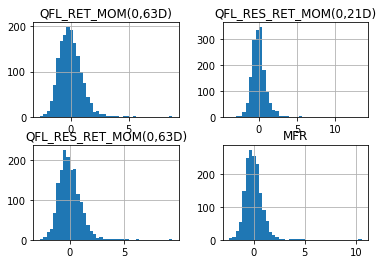

In [51]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [52]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.09
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [53]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.09
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [54]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.07
Information Coefficient (P-Value): 0.01


### Z-Score Only (All Components)

In [55]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
